In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.api import Logit
import patsy
from joblib import load, dump

import model_functions as mf
import eval_measures as ems

MF reloaded 1
EMS reloaded


In [2]:
sns.set_context('poster')
sns.set_style('ticks')

plt.rcParams['font.size'] = 9 
plt.rcParams['axes.labelsize'] = 9 
plt.rcParams['xtick.labelsize'] = 9 
plt.rcParams['ytick.labelsize'] = 9 
plt.rcParams['axes.titlesize'] = 9 
plt.rcParams['font.family'] = 'serif'
plt.rcParams['savefig.dpi'] = 600 

In [3]:
with pd.HDFStore("out/Training_2002_2005.h5") as store:
    print store
    df = store["first_author"]

<class 'pandas.io.pytables.HDFStore'>
File path: out/Training_2002_2005.h5
/first_author            frame        (shape->[41618369,56])
/last_author             frame        (shape->[41618369,56])


## Pre-process data

In [4]:
GENDERS = ["-", "F", "M"]
TOP_15_ETHNICITIES = ["ENGLISH", "GERMAN", "HISPANIC", "CHINESE",
                      "JAPANESE", "SLAV", "FRENCH", "ITALIAN", "INDIAN",
                      "NORDIC", "ARAB", "DUTCH", "KOREAN", "UNKNOWN", "OTHER"]
TOP_15_COUNTRIES = ["USA", "UNKNOWN", "UK", "JAPAN", "GERMANY", "FRANCE", "ITALY",
                    "CANADA", "CHINA", "AUSTRALIA", "SPAIN", "NETHERLANDS",
                    "SWEDEN", "INDIA", "OTHER"]

### Pre-process Gender

In [5]:
df.gender = df.gender.astype("category", categories=GENDERS, ordered=False).fillna("-")

### Pre-process Ethnicity

In [6]:
df["eth_weight"] = 0.5 # Partial weight to multi ethnicity
df.ix[df.eth2 == "UNKNOWN", "eth_weight"] = 1 # Full weight to single ethnicity

df.ix[df.eth1.isin(
        ["UNKNOWN", "TOOSHORT", "ERROR"]),
      "eth1"] = "UNKNOWN" # Set unknown ethnicities
df.ix[df.eth2.isin(
        ["UNKNOWN", "TOOSHORT", "ERROR"]),
      "eth2"] = "UNKNOWN" # Set unknown ethnicities

df.eth1 = df.eth1.astype("category", categories=TOP_15_ETHNICITIES, ordered=False).fillna("OTHER")
df.eth2 = df.eth2.astype("category", categories=TOP_15_ETHNICITIES, ordered=False).fillna("OTHER")

### Pre-process Affiliation

In [7]:
df.ix[df.source_country == "-", "source_country"] = "UNKNOWN" # Set - to unknown
df.source_country = df.source_country.astype("category", categories=TOP_15_COUNTRIES, ordered=False).fillna("OTHER")

### Fix data types

In [8]:
df[[u'source_is_eng', u'source_is_journal', u'source_is_review',
    u'source_is_case_rep', u'source_is_let_ed_com',
    u'sink_is_eng', u'sink_is_journal', u'sink_is_review', u'sink_is_case_rep',
    u'sink_is_let_ed_com', u'journal_same', u'affiliation_sim']] = df[[u'source_is_eng', u'source_is_journal', u'source_is_review',
    u'source_is_case_rep', u'source_is_let_ed_com',
    u'sink_is_eng', u'sink_is_journal', u'sink_is_review', u'sink_is_case_rep',
    u'sink_is_let_ed_com', u'journal_same', u'affiliation_sim']].astype("bool")

## Select Source Journal Names

Top 3 overall journals using H-index and with atleast 4000 citable documents in past 3 years.

http://www.scimagojr.com/journalrank.php?order=h&ord=desc&min=4000&min_type=cd

* Nature
* Science
* Proceedings of the National Academy of Sciences of the United States of America

Top 3 overall journals in Medicine (miscellenous) category using H-index and with atleast 4000 citable documents in past 3 years.

http://www.scimagojr.com/journalrank.php?category=2701&order=h&ord=desc&min=1000&min_type=cd

* New England Journal of Medicine
* Lancet
* JAMA - Journal of the American Medical Association


Date: 06/08/2016

In [9]:
df["source_j"].head()

0       J AOAC Int
1       J AOAC Int
2    J Comp Neurol
3    J Comp Neurol
4    J Comp Neurol
Name: source_j, dtype: object

In [10]:
top_journals = df["sink_j"].value_counts().sort_values(ascending=False).head(50)

In [11]:
top_journals

J Biol Chem                   1388613
Proc Natl Acad Sci U S A      1122030
Nature                         823266
Science                        790844
Lancet                         492380
Cell                           487535
N Engl J Med                   478937
J Immunol                      396642
Cancer Res                     370269
Circulation                    352157
Blood                          325512
Biochemistry                   311992
J Neurosci                     311404
EMBO J                         282204
J Clin Invest                  277685
J Virol                        269501
Mol Cell Biol                  249099
J Cell Biol                    247899
JAMA                           236754
J Exp Med                      231693
Biochem Biophys Res Commun     222723
Nucleic Acids Res              215937
Cancer                         206795
Biochim Biophys Acta           204417
J Mol Biol                     201713
Brain Res                      201174
Am J Physiol

In [12]:
MODEL_VERSION = "v4"
MODEL_SUFFIX = "%s.first_author" % MODEL_VERSION

MULTIDISCIPLINARY_JOURNAL_NAMES = [("Nature", "Nature"), ("Science", "Science"),  ("PNAS", "Proc Natl Acad Sci U S A")]
MEDICAL_JOURNAL_NAMES = [("NEJM", "N Engl J Med"),
                         ("Lancet", "Lancet"),
                         ("JAMA", "JAMA")]


## Model fitting

In [13]:
def plot_prc(prc, ax, color="k", label="PRC"):
    precision, recall = prc
    ax.plot(recall, precision, 
            marker="None", linestyle="-",
            color=color, label=label)

def get_all_eval_measures(predict, endog, include_prc=False):
    measures = {}
    pred_table = ems.cm(predict, endog)
    measures["precision"] = ems.precision(pred_table)
    measures["recall"] = ems.recall(pred_table)
    measures["accuracy"] = ems.accuracy(pred_table)
    measures["f_score"] = ems.fscore_measure(pred_table)
    measures["rmse"] = ems.rmse(predict, endog)
    measures["mae"] = ems.mae(predict, endog)
    measures["auc"] = ems.auc(predict, endog)
    tn, fp, fn, tp = map(float, pred_table.flatten()) # WRT to 1 as positive label
    measures["tn"] = tn
    measures["fn"] = fn
    measures["fp"] = fp
    measures["tp"] = tp
    measures["tpr"] = tp * 1. / (tp + fn) 
    measures["fpr"] = fp * 1. / (fp + tn) 
    print "In eval measures function."
    if include_prc:
        ## Include the precision recall values
        prc = ems.prc(predict, endog, float_precision=3)
        measures["prc"] = prc
        roc = ems.roc(predict, endog, float_precision=3)
        measures["roc"] = roc
    return measures


def model_fit(df, formula, testing=False, include_prc=False):
    if testing:
        # If testing the just print X and y columns
        print df.shape, formula, include_prc
        return ({"llf": 0.1}, "TEMP SUMMARY")
    ## Not testing. Fit the models and return the measures
    print df.shape, formula, include_prc
    y,X = patsy.dmatrices(formula, data=df, return_type="dataframe")
    print "Created dataframes"
    print "X.shape = %s, y.shape = %s" % (X.shape, y.shape)
    model = Logit(y,X)
    res = model.fit()
    predict = res.predict()
    measures = get_all_eval_measures(predict, model.endog, include_prc=include_prc)
    measures["llf"] = res.llf
    measures["aic"] = res.aic
    measures["bic"] = res.bic
    measures["prsquared"] = res.prsquared
    measures["df_model"] = res.df_model
    return (measures, res.summary2())


## Ommited factors in journal models 

* Since all the considered journals publish english articles hence we remove `source_is_eng` as factor from their models
* Since multi disciplinary journals don't publish case reports hence we remove `source_is_case_rep` as a factor from their models as well

In [14]:
base_formula = ("is_self_cite ~ I(auth_prev_papers == 0) + I(auth_prev_papers == 1) "
           "+ np.log10(auth_prev_papers + 1) + I(np.log10(auth_prev_papers + 1)**2)"
           "+ C(gender, levels=GENDERS) + C(source_country, levels=TOP_15_COUNTRIES)"
           "+ mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)"
           "+ I(source_ncites == 1) + np.log10(source_ncites) "
           "+ I(np.log10(source_ncites)**2) + I(np.log10(source_ncites)**3)"
           "+ I(source_n_authors > 20) + np.log10(np.clip(source_n_authors, 0, 20))"
           "+ I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)"
           "+ np.log10(source_n_mesh_ex + 1) + I(source_n_mesh_ex == 0)" 
           "+ np.log10(sink_n_mesh_ex + 1) + I(sink_n_mesh_ex == 0)"
           "+ I(year_span < 0) + I(year_span == 0) + mf.score_log_1(year_span) + I(mf.score_log_1(year_span)**2)"
           "+ I(sink_prev_ncites == 0) + np.log10(sink_prev_ncites + 1) + I(np.log10(sink_prev_ncites + 1)**2)"
           "+ I(jj_sim == 0) + np.log10(jj_sim + 1) + I(np.log10(jj_sim + 1)**2) + journal_same"
           "+ source_is_journal + source_is_review + source_is_let_ed_com"
           "+ sink_is_eng + sink_is_journal + sink_is_review + sink_is_case_rep + sink_is_let_ed_com"
           "+ np.log10(np.nan_to_num(source_V_novelty) + 1)"
           "+ np.log10(np.nan_to_num(sink_V_novelty) + 1) + I(np.log10(np.nan_to_num(sink_V_novelty) + 1)**2)"
          )

## REMOVED factors "+ source_is_eng + source_is_case_rep"
med_j_formula = "+ source_is_case_rep"

In [15]:
from IPython.display import display

Created figure with 2 rows and 3 columns
(69181, 57) is_self_cite ~ I(auth_prev_papers == 0) + I(auth_prev_papers == 1) + np.log10(auth_prev_papers + 1) + I(np.log10(auth_prev_papers + 1)**2)+ C(gender, levels=GENDERS) + C(source_country, levels=TOP_15_COUNTRIES)+ mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)+ I(source_ncites == 1) + np.log10(source_ncites) + I(np.log10(source_ncites)**2) + I(np.log10(source_ncites)**3)+ I(source_n_authors > 20) + np.log10(np.clip(source_n_authors, 0, 20))+ I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)+ np.log10(source_n_mesh_ex + 1) + I(source_n_mesh_ex == 0)+ np.log10(sink_n_mesh_ex + 1) + I(sink_n_mesh_ex == 0)+ I(year_span < 0) + I(year_span == 0) + mf.score_log_1(year_span) + I(mf.score_log_1(year_span)**2)+ I(sink_prev_ncites == 0) + np.log10(sink_prev_ncites + 1) + I(np.log10(sink_prev_ncites + 1)**2)+ I(jj_sim == 0) + np.log10(jj_sim + 1) + I(np.log10(jj_sim + 1)**2) + journal_same+ source_is_journal + source_is_review +

/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In eval measures function.
0 Nature Nature
{'fp': 34.0, 'auc': 0.79088170808456282, 'rmse': 0.22577720920242517, 'prsquared': 0.13677178499992482, 'recall': 0.003772635814889336, 'precision': 0.30612244897959184, 'f_score': 0.007453416149068324, 'bic': 27028.856279391697, 'tn': 65171.0, 'df_model': 67.0, 'aic': 26407.031534846355, 'mae': 0.10107125859548403, 'tp': 15.0, 'fpr': 0.0005214324054903765, 'tpr': 0.003772635814889336, 'llf': -13135.515767423178, 'fn': 3961.0, 'accuracy': 0.9422529307179717}


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                      Results: Logit
===========================================================================================================================
Model:                                  Logit                               Pseudo R-squared:                    0.137     
Dependent Variable:                     is_self_cite                        AIC:                                 26407.0315
Date:                                   2016-06-14 12:39                    BIC:                                 27028.8563
No. Observations:                       69181                               Log-Likelihood:                      -13136.   
Df Model:                               67                                  LL-Null:                             -15217.   
Df Residuals:                           69113                               LLR p-value:                         0.0000    
Converged:                              0.0000                              Scale:                               1.0000    
No. Iterations:                         35.0000                                                                            
---------------------------------------------------------------------------------------------------------------------------
                                                                      Coef.   Std.Err.    z     P>|z|    [0.025     0.975] 
---------------------------------------------------------------------------------------------------------------------------
Intercept                                                            -16.3484 776.1628  -0.0211 0.9832 -1537.5994 1504.9027
I(auth_prev_papers == 0)[T.True]                                      -1.4035   0.1666  -8.4249 0.0000    -1.7300   -1.0770
I(auth_prev_papers == 1)[T.True]                                      -0.1632   0.0948  -1.7220 0.0851    -0.3490    0.0226
C(gender, levels=GENDERS)[T.F]                                        -0.0948   0.0764  -1.2409 0.2146    -0.2445    0.0549
C(gender, levels=GENDERS)[T.M]                                        -0.0418   0.0649  -0.6446 0.5192    -0.1691    0.0854
C(source_country, levels=TOP_15_COUNTRIES)[T.UNKNOWN]                  0.1599   0.1588   1.0070 0.3139    -0.1513    0.4711
C(source_country, levels=TOP_15_COUNTRIES)[T.UK]                       0.0528   0.0568   0.9301 0.3523    -0.0585    0.1641
C(source_country, levels=TOP_15_COUNTRIES)[T.JAPAN]                    0.4023   0.1151   3.4940 0.0005     0.1766    0.6279
C(source_country, levels=TOP_15_COUNTRIES)[T.GERMANY]                 -0.0023   0.0877  -0.0257 0.9795    -0.1742    0.1697
C(source_country, levels=TOP_15_COUNTRIES)[T.FRANCE]                   0.0377   0.1142   0.3300 0.7414    -0.1862    0.2615
C(source_country, levels=TOP_15_COUNTRIES)[T.ITALY]                   -0.0755   0.1727  -0.4371 0.6621    -0.4140    0.2630
C(source_country, levels=TOP_15_COUNTRIES)[T.CANADA]                  -0.2166   0.1326  -1.6331 0.1025    -0.4765    0.0434
C(source_country, levels=TOP_15_COUNTRIES)[T.CHINA]                    0.3403   0.1700   2.0020 0.0453     0.0072    0.6735
C(source_country, levels=TOP_15_COUNTRIES)[T.AUSTRALIA]                0.0548   0.1488   0.3683 0.7126    -0.2368    0.3464
C(source_country, levels=TOP_15_COUNTRIES)[T.SPAIN]                    0.0754   0.2570   0.2932 0.7694    -0.4284    0.5791
C(source_country, levels=TOP_15_COUNTRIES)[T.NETHERLANDS]             -0.0363   0.1630  -0.2226 0.8238    -0.3558    0.2833
C(source_country, levels=TOP_15_COUNTRIES)[T.SWEDEN]                  -0.0130   0.2297  -0.0568 0.9547    -0.4632    0.4371
C(source_country, levels=TOP_15_COUNTRIES)[T.INDIA]                    0.3727   0.7359   0.5065 0.6125    -1.0697    1.8151
C(source_country, levels=TOP_15_COUNTRIES)[T.OTHER]                    0.1654   0.0744   2.2236 0.0262     0.0196    0.3112
I(source_ncites == 1)[T.True]         

None
(61122, 57) is_self_cite ~ I(auth_prev_papers == 0) + I(auth_prev_papers == 1) + np.log10(auth_prev_papers + 1) + I(np.log10(auth_prev_papers + 1)**2)+ C(gender, levels=GENDERS) + C(source_country, levels=TOP_15_COUNTRIES)+ mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)+ I(source_ncites == 1) + np.log10(source_ncites) + I(np.log10(source_ncites)**2) + I(np.log10(source_ncites)**3)+ I(source_n_authors > 20) + np.log10(np.clip(source_n_authors, 0, 20))+ I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)+ np.log10(source_n_mesh_ex + 1) + I(source_n_mesh_ex == 0)+ np.log10(sink_n_mesh_ex + 1) + I(sink_n_mesh_ex == 0)+ I(year_span < 0) + I(year_span == 0) + mf.score_log_1(year_span) + I(mf.score_log_1(year_span)**2)+ I(sink_prev_ncites == 0) + np.log10(sink_prev_ncites + 1) + I(np.log10(sink_prev_ncites + 1)**2)+ I(jj_sim == 0) + np.log10(jj_sim + 1) + I(np.log10(jj_sim + 1)**2) + journal_same+ source_is_journal + source_is_review + source_is_let_ed_com+ sink_is_eng +

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                    Results: Logit
=======================================================================================================================
Model:                                Logit                              Pseudo R-squared:                   0.130     
Dependent Variable:                   is_self_cite                       AIC:                                25185.8344
Date:                                 2016-06-14 12:39                   BIC:                                25799.2370
No. Observations:                     61122                              Log-Likelihood:                     -12525.   
Df Model:                             67                                 LL-Null:                            -14398.   
Df Residuals:                         61054                              LLR p-value:                        0.0000    
Converged:                            1.0000                             Scale:                              1.0000    
No. Iterations:                       9.0000                                                                           
-----------------------------------------------------------------------------------------------------------------------
                                                                      Coef.   Std.Err.    z     P>|z|   [0.025   0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                                              6.6669   3.1938   2.0874 0.0368   0.4071 12.9267
I(auth_prev_papers == 0)[T.True]                                      -1.3136   0.1666  -7.8827 0.0000  -1.6403 -0.9870
I(auth_prev_papers == 1)[T.True]                                      -0.2590   0.1005  -2.5780 0.0099  -0.4559 -0.0621
C(gender, levels=GENDERS)[T.F]                                        -0.0904   0.0832  -1.0869 0.2771  -0.2534  0.0726
C(gender, levels=GENDERS)[T.M]                                         0.0418   0.0749   0.5576 0.5771  -0.1051  0.1886
C(source_country, levels=TOP_15_COUNTRIES)[T.UNKNOWN]                  0.0712   0.1914   0.3721 0.7098  -0.3039  0.4463
C(source_country, levels=TOP_15_COUNTRIES)[T.UK]                      -0.0183   0.0622  -0.2940 0.7688  -0.1401  0.1036
C(source_country, levels=TOP_15_COUNTRIES)[T.JAPAN]                    0.4895   0.1506   3.2497 0.0012   0.1943  0.7847
C(source_country, levels=TOP_15_COUNTRIES)[T.GERMANY]                  0.1013   0.0924   1.0959 0.2731  -0.0799  0.2824
C(source_country, levels=TOP_15_COUNTRIES)[T.FRANCE]                   0.3081   0.1138   2.7074 0.0068   0.0851  0.5311
C(source_country, levels=TOP_15_COUNTRIES)[T.ITALY]                    0.3193   0.1787   1.7869 0.0739  -0.0309  0.6695
C(source_country, levels=TOP_15_COUNTRIES)[T.CANADA]                  -0.1187   0.1129  -1.0512 0.2932  -0.3401  0.1026
C(source_country, levels=TOP_15_COUNTRIES)[T.CHINA]                   -0.1604   0.2952  -0.5433 0.5869  -0.7389  0.4182
C(source_country, levels=TOP_15_COUNTRIES)[T.AUSTRALIA]               -0.0430   0.1680  -0.2560 0.7980  -0.3723  0.2863
C(source_country, levels=TOP_15_COUNTRIES)[T.SPAIN]                    0.1031   0.4151   0.2484 0.8038  -0.7105  0.9166
C(source_country, levels=TOP_15_COUNTRIES)[T.NETHERLANDS]             -0.1558   0.1763  -0.8838 0.3768  -0.5014  0.1897
C(source_country, levels=TOP_15_COUNTRIES)[T.SWEDEN]                   0.1381   0.2321   0.5950 0.5518  -0.3168  0.5930
C(source_country, levels=TOP_15_COUNTRIES)[T.INDIA]                    0.3846   0.6362   0.6045 0.5455  -0.8624  1.6316
C(source_country, levels=TOP_15_COUNTRIES)[T.OTHER]                    0.0470   0.0754   0.6238 0.5328  -0.1008  0.1948
I(source_ncites == 1)[T.True]                                          0.4358   0.3155   1.3814 0.1671  -0.1825  1.0541
I(source_n_authors > 20)[T.True]            

None
(384115, 57) is_self_cite ~ I(auth_prev_papers == 0) + I(auth_prev_papers == 1) + np.log10(auth_prev_papers + 1) + I(np.log10(auth_prev_papers + 1)**2)+ C(gender, levels=GENDERS) + C(source_country, levels=TOP_15_COUNTRIES)+ mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)+ I(source_ncites == 1) + np.log10(source_ncites) + I(np.log10(source_ncites)**2) + I(np.log10(source_ncites)**3)+ I(source_n_authors > 20) + np.log10(np.clip(source_n_authors, 0, 20))+ I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)+ np.log10(source_n_mesh_ex + 1) + I(source_n_mesh_ex == 0)+ np.log10(sink_n_mesh_ex + 1) + I(sink_n_mesh_ex == 0)+ I(year_span < 0) + I(year_span == 0) + mf.score_log_1(year_span) + I(mf.score_log_1(year_span)**2)+ I(sink_prev_ncites == 0) + np.log10(sink_prev_ncites + 1) + I(np.log10(sink_prev_ncites + 1)**2)+ I(jj_sim == 0) + np.log10(jj_sim + 1) + I(np.log10(jj_sim + 1)**2) + journal_same+ source_is_journal + source_is_review + source_is_let_ed_com+ sink_is_eng 

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                   Results: Logit
=====================================================================================================================
Model:                               Logit                             Pseudo R-squared:                  0.180      
Dependent Variable:                  is_self_cite                      AIC:                               122094.1379
Date:                                2016-06-14 12:39                  BIC:                               122832.5293
No. Observations:                    384115                            Log-Likelihood:                    -60979.    
Df Model:                            67                                LL-Null:                           -74405.    
Df Residuals:                        384047                            LLR p-value:                       0.0000     
Converged:                           1.0000                            Scale:                             1.0000     
No. Iterations:                      10.0000                                                                         
---------------------------------------------------------------------------------------------------------------------
                                                                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                                            -6.3827   1.3463  -4.7410 0.0000 -9.0213 -3.7440
I(auth_prev_papers == 0)[T.True]                                     -1.3467   0.0926 -14.5458 0.0000 -1.5282 -1.1653
I(auth_prev_papers == 1)[T.True]                                     -0.2726   0.0495  -5.5103 0.0000 -0.3695 -0.1756
C(gender, levels=GENDERS)[T.F]                                       -0.1328   0.0319  -4.1597 0.0000 -0.1954 -0.0702
C(gender, levels=GENDERS)[T.M]                                       -0.1536   0.0290  -5.3022 0.0000 -0.2103 -0.0968
C(source_country, levels=TOP_15_COUNTRIES)[T.UNKNOWN]                -0.2743   0.1604  -1.7101 0.0872 -0.5887  0.0401
C(source_country, levels=TOP_15_COUNTRIES)[T.UK]                     -0.0475   0.0392  -1.2123 0.2254 -0.1242  0.0293
C(source_country, levels=TOP_15_COUNTRIES)[T.JAPAN]                   0.3698   0.0508   7.2782 0.0000  0.2702  0.4693
C(source_country, levels=TOP_15_COUNTRIES)[T.GERMANY]                 0.0746   0.0429   1.7365 0.0825 -0.0096  0.1588
C(source_country, levels=TOP_15_COUNTRIES)[T.FRANCE]                  0.0708   0.0513   1.3793 0.1678 -0.0298  0.1713
C(source_country, levels=TOP_15_COUNTRIES)[T.ITALY]                   0.0463   0.0705   0.6574 0.5109 -0.0918  0.1844
C(source_country, levels=TOP_15_COUNTRIES)[T.CANADA]                  0.0048   0.0542   0.0883 0.9297 -0.1015  0.1110
C(source_country, levels=TOP_15_COUNTRIES)[T.CHINA]                  -0.2252   0.1541  -1.4615 0.1439 -0.5273  0.0768
C(source_country, levels=TOP_15_COUNTRIES)[T.AUSTRALIA]               0.0374   0.0709   0.5269 0.5983 -0.1016  0.1764
C(source_country, levels=TOP_15_COUNTRIES)[T.SPAIN]                   0.0598   0.0920   0.6502 0.5156 -0.1204  0.2400
C(source_country, levels=TOP_15_COUNTRIES)[T.NETHERLANDS]             0.2148   0.0952   2.2559 0.0241  0.0282  0.4014
C(source_country, levels=TOP_15_COUNTRIES)[T.SWEDEN]                  0.1073   0.0712   1.5064 0.1320 -0.0323  0.2470
C(source_country, levels=TOP_15_COUNTRIES)[T.INDIA]                   0.2896   0.2682   1.0799 0.2802 -0.2360  0.8152
C(source_country, levels=TOP_15_COUNTRIES)[T.OTHER]                   0.1062   0.0338   3.1457 0.0017  0.0400  0.1724
I(source_ncites == 1)[T.True]                                         1.3849   0.5086   2.7233 0.0065  0.3882  2.3817
I(source_n_authors > 20)[T.True]                                     -0.3352   0.0914  -3.6664 0.0002 -0.5144

None
(55775, 57) is_self_cite ~ I(auth_prev_papers == 0) + I(auth_prev_papers == 1) + np.log10(auth_prev_papers + 1) + I(np.log10(auth_prev_papers + 1)**2)+ C(gender, levels=GENDERS) + C(source_country, levels=TOP_15_COUNTRIES)+ mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)+ I(source_ncites == 1) + np.log10(source_ncites) + I(np.log10(source_ncites)**2) + I(np.log10(source_ncites)**3)+ I(source_n_authors > 20) + np.log10(np.clip(source_n_authors, 0, 20))+ I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)+ np.log10(source_n_mesh_ex + 1) + I(source_n_mesh_ex == 0)+ np.log10(sink_n_mesh_ex + 1) + I(sink_n_mesh_ex == 0)+ I(year_span < 0) + I(year_span == 0) + mf.score_log_1(year_span) + I(mf.score_log_1(year_span)**2)+ I(sink_prev_ncites == 0) + np.log10(sink_prev_ncites + 1) + I(np.log10(sink_prev_ncites + 1)**2)+ I(jj_sim == 0) + np.log10(jj_sim + 1) + I(np.log10(jj_sim + 1)**2) + journal_same+ source_is_journal + source_is_review + source_is_let_ed_com+ sink_is_eng +

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                    Results: Logit
======================================================================================================================
Model:                                 Logit                             Pseudo R-squared:                  0.127     
Dependent Variable:                    is_self_cite                      AIC:                               25219.3610
Date:                                  2016-06-14 12:39                  BIC:                               25835.4676
No. Observations:                      55775                             Log-Likelihood:                    -12541.   
Df Model:                              68                                LL-Null:                           -14370.   
Df Residuals:                          55706                             LLR p-value:                       0.0000    
Converged:                             1.0000                            Scale:                             1.0000    
No. Iterations:                        9.0000                                                                         
----------------------------------------------------------------------------------------------------------------------
                                                                      Coef.   Std.Err.    z    P>|z|   [0.025   0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                                            -11.3834   1.9445 -5.8541 0.0000 -15.1946 -7.5723
I(auth_prev_papers == 0)[T.True]                                       0.1325   0.2972  0.4460 0.6556  -0.4500  0.7150
I(auth_prev_papers == 1)[T.True]                                       0.1879   0.2528  0.7434 0.4572  -0.3076  0.6834
C(gender, levels=GENDERS)[T.F]                                         0.0035   0.0939  0.0369 0.9705  -0.1807  0.1876
C(gender, levels=GENDERS)[T.M]                                        -0.0274   0.0838 -0.3266 0.7439  -0.1916  0.1369
C(source_country, levels=TOP_15_COUNTRIES)[T.UNKNOWN]                  0.0739   0.1033  0.7157 0.4742  -0.1285  0.2764
C(source_country, levels=TOP_15_COUNTRIES)[T.UK]                       0.0168   0.0793  0.2118 0.8323  -0.1387  0.1722
C(source_country, levels=TOP_15_COUNTRIES)[T.JAPAN]                   -0.3857   0.3484 -1.1071 0.2682  -1.0684  0.2971
C(source_country, levels=TOP_15_COUNTRIES)[T.GERMANY]                  0.1007   0.1156  0.8717 0.3834  -0.1258  0.3273
C(source_country, levels=TOP_15_COUNTRIES)[T.FRANCE]                   0.2002   0.1189  1.6838 0.0922  -0.0328  0.4332
C(source_country, levels=TOP_15_COUNTRIES)[T.ITALY]                    0.4414   0.1466  3.0096 0.0026   0.1539  0.7288
C(source_country, levels=TOP_15_COUNTRIES)[T.CANADA]                   0.0544   0.0927  0.5860 0.5579  -0.1274  0.2361
C(source_country, levels=TOP_15_COUNTRIES)[T.CHINA]                    2.0158   1.4242  1.4154 0.1570  -0.7756  4.8072
C(source_country, levels=TOP_15_COUNTRIES)[T.AUSTRALIA]                0.6669   0.1561  4.2727 0.0000   0.3610  0.9728
C(source_country, levels=TOP_15_COUNTRIES)[T.SPAIN]                    0.3048   0.1727  1.7644 0.0777  -0.0338  0.6433
C(source_country, levels=TOP_15_COUNTRIES)[T.NETHERLANDS]              0.3372   0.1870  1.8029 0.0714  -0.0294  0.7037
C(source_country, levels=TOP_15_COUNTRIES)[T.SWEDEN]                   0.0845   0.2071  0.4080 0.6832  -0.3214  0.4904
C(source_country, levels=TOP_15_COUNTRIES)[T.INDIA]                    0.0943   0.4373  0.2156 0.8293  -0.7627  0.9513
C(source_country, levels=TOP_15_COUNTRIES)[T.OTHER]                    0.1262   0.0690  1.8286 0.0675  -0.0091  0.2615
I(source_ncites == 1)[T.True]                                         -0.5159   0.3092 -1.6687 0.0952  -1.1219  0.0901
I(source_n_authors > 20)[T.True]                                       0.132

None
(60272, 57) is_self_cite ~ I(auth_prev_papers == 0) + I(auth_prev_papers == 1) + np.log10(auth_prev_papers + 1) + I(np.log10(auth_prev_papers + 1)**2)+ C(gender, levels=GENDERS) + C(source_country, levels=TOP_15_COUNTRIES)+ mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)+ I(source_ncites == 1) + np.log10(source_ncites) + I(np.log10(source_ncites)**2) + I(np.log10(source_ncites)**3)+ I(source_n_authors > 20) + np.log10(np.clip(source_n_authors, 0, 20))+ I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)+ np.log10(source_n_mesh_ex + 1) + I(source_n_mesh_ex == 0)+ np.log10(sink_n_mesh_ex + 1) + I(sink_n_mesh_ex == 0)+ I(year_span < 0) + I(year_span == 0) + mf.score_log_1(year_span) + I(mf.score_log_1(year_span)**2)+ I(sink_prev_ncites == 0) + np.log10(sink_prev_ncites + 1) + I(np.log10(sink_prev_ncites + 1)**2)+ I(jj_sim == 0) + np.log10(jj_sim + 1) + I(np.log10(jj_sim + 1)**2) + journal_same+ source_is_journal + source_is_review + source_is_let_ed_com+ sink_is_eng +

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                   Results: Logit
====================================================================================================================
Model:                               Logit                             Pseudo R-squared:                  0.110     
Dependent Variable:                  is_self_cite                      AIC:                               30250.0548
Date:                                2016-06-14 12:39                  BIC:                               30871.5118
No. Observations:                    60272                             Log-Likelihood:                    -15056.   
Df Model:                            68                                LL-Null:                           -16924.   
Df Residuals:                        60203                             LLR p-value:                       0.0000    
Converged:                           1.0000                            Scale:                             1.0000    
No. Iterations:                      10.0000                                                                        
--------------------------------------------------------------------------------------------------------------------
                                                                      Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                                            -4.0173   1.6477 -2.4382 0.0148 -7.2467 -0.7879
I(auth_prev_papers == 0)[T.True]                                     -1.4147   0.3208 -4.4103 0.0000 -2.0434 -0.7860
I(auth_prev_papers == 1)[T.True]                                     -0.1515   0.1878 -0.8069 0.4197 -0.5196  0.2165
C(gender, levels=GENDERS)[T.F]                                       -0.1890   0.0803 -2.3541 0.0186 -0.3464 -0.0316
C(gender, levels=GENDERS)[T.M]                                       -0.1392   0.0718 -1.9403 0.0523 -0.2799  0.0014
C(source_country, levels=TOP_15_COUNTRIES)[T.UNKNOWN]                -0.3222   0.0917 -3.5128 0.0004 -0.5019 -0.1424
C(source_country, levels=TOP_15_COUNTRIES)[T.UK]                     -0.2144   0.0453 -4.7322 0.0000 -0.3032 -0.1256
C(source_country, levels=TOP_15_COUNTRIES)[T.JAPAN]                  -0.0880   0.2683 -0.3280 0.7429 -0.6139  0.4379
C(source_country, levels=TOP_15_COUNTRIES)[T.GERMANY]                -0.3142   0.1022 -3.0735 0.0021 -0.5146 -0.1139
C(source_country, levels=TOP_15_COUNTRIES)[T.FRANCE]                 -0.0438   0.1066 -0.4105 0.6814 -0.2527  0.1652
C(source_country, levels=TOP_15_COUNTRIES)[T.ITALY]                  -0.4128   0.1445 -2.8565 0.0043 -0.6961 -0.1296
C(source_country, levels=TOP_15_COUNTRIES)[T.CANADA]                 -0.1413   0.0986 -1.4327 0.1519 -0.3346  0.0520
C(source_country, levels=TOP_15_COUNTRIES)[T.CHINA]                  -0.1719   0.3304 -0.5204 0.6028 -0.8194  0.4756
C(source_country, levels=TOP_15_COUNTRIES)[T.AUSTRALIA]              -0.1031   0.0782 -1.3176 0.1876 -0.2564  0.0502
C(source_country, levels=TOP_15_COUNTRIES)[T.SPAIN]                  -0.1418   0.1718 -0.8253 0.4092 -0.4786  0.1950
C(source_country, levels=TOP_15_COUNTRIES)[T.NETHERLANDS]            -0.0095   0.1329 -0.0717 0.9428 -0.2700  0.2509
C(source_country, levels=TOP_15_COUNTRIES)[T.SWEDEN]                 -0.0850   0.1392 -0.6112 0.5411 -0.3578  0.1877
C(source_country, levels=TOP_15_COUNTRIES)[T.INDIA]                  -0.5303   0.2289 -2.3171 0.0205 -0.9788 -0.0817
C(source_country, levels=TOP_15_COUNTRIES)[T.OTHER]                  -0.0257   0.0552 -0.4654 0.6416 -0.1338  0.0825
I(source_ncites == 1)[T.True]                                        -0.3387   0.3085 -1.0978 0.2723 -0.9435  0.2660
I(source_n_authors > 20)[T.True]                                     -0.4145   0.1738 -2.3849 0.0171 -0.7551 -0.0738
I(source_n_mesh_ex == 0)

None
(49935, 57) is_self_cite ~ I(auth_prev_papers == 0) + I(auth_prev_papers == 1) + np.log10(auth_prev_papers + 1) + I(np.log10(auth_prev_papers + 1)**2)+ C(gender, levels=GENDERS) + C(source_country, levels=TOP_15_COUNTRIES)+ mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)+ I(source_ncites == 1) + np.log10(source_ncites) + I(np.log10(source_ncites)**2) + I(np.log10(source_ncites)**3)+ I(source_n_authors > 20) + np.log10(np.clip(source_n_authors, 0, 20))+ I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)+ np.log10(source_n_mesh_ex + 1) + I(source_n_mesh_ex == 0)+ np.log10(sink_n_mesh_ex + 1) + I(sink_n_mesh_ex == 0)+ I(year_span < 0) + I(year_span == 0) + mf.score_log_1(year_span) + I(mf.score_log_1(year_span)**2)+ I(sink_prev_ncites == 0) + np.log10(sink_prev_ncites + 1) + I(np.log10(sink_prev_ncites + 1)**2)+ I(jj_sim == 0) + np.log10(jj_sim + 1) + I(np.log10(jj_sim + 1)**2) + journal_same+ source_is_journal + source_is_review + source_is_let_ed_com+ sink_is_eng +

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                   Results: Logit
====================================================================================================================
Model:                               Logit                             Pseudo R-squared:                  0.146     
Dependent Variable:                  is_self_cite                      AIC:                               20531.8909
Date:                                2016-06-14 12:39                  BIC:                               21140.3658
No. Observations:                    49935                             Log-Likelihood:                    -10197.   
Df Model:                            68                                LL-Null:                           -11944.   
Df Residuals:                        49866                             LLR p-value:                       0.0000    
Converged:                           1.0000                            Scale:                             1.0000    
No. Iterations:                      10.0000                                                                        
--------------------------------------------------------------------------------------------------------------------
                                                                      Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                                            -5.9219   1.2776 -4.6354 0.0000 -8.4259 -3.4180
I(auth_prev_papers == 0)[T.True]                                     -0.2133   0.3380 -0.6310 0.5280 -0.8759  0.4492
I(auth_prev_papers == 1)[T.True]                                      0.0294   0.2555  0.1149 0.9085 -0.4714  0.5302
C(gender, levels=GENDERS)[T.F]                                       -0.1092   0.1068 -1.0228 0.3064 -0.3186  0.1001
C(gender, levels=GENDERS)[T.M]                                       -0.2291   0.1020 -2.2469 0.0246 -0.4290 -0.0293
C(source_country, levels=TOP_15_COUNTRIES)[T.UNKNOWN]                -0.0764   0.1215 -0.6293 0.5291 -0.3145  0.1616
C(source_country, levels=TOP_15_COUNTRIES)[T.UK]                      0.2039   0.1355  1.5046 0.1324 -0.0617  0.4696
C(source_country, levels=TOP_15_COUNTRIES)[T.JAPAN]                   0.2198   0.6804  0.3230 0.7467 -1.1139  1.5534
C(source_country, levels=TOP_15_COUNTRIES)[T.GERMANY]                -0.1598   0.1569 -1.0184 0.3085 -0.4673  0.1477
C(source_country, levels=TOP_15_COUNTRIES)[T.FRANCE]                 -0.1998   0.2009 -0.9943 0.3201 -0.5935  0.1940
C(source_country, levels=TOP_15_COUNTRIES)[T.ITALY]                   0.4035   0.1734  2.3273 0.0199  0.0637  0.7434
C(source_country, levels=TOP_15_COUNTRIES)[T.CANADA]                  0.0274   0.0916  0.2993 0.7647 -0.1521  0.2069
C(source_country, levels=TOP_15_COUNTRIES)[T.CHINA]                  -0.6297   0.7323 -0.8599 0.3898 -2.0651  0.8056
C(source_country, levels=TOP_15_COUNTRIES)[T.AUSTRALIA]              -0.3531   0.1823 -1.9372 0.0527 -0.7103  0.0041
C(source_country, levels=TOP_15_COUNTRIES)[T.SPAIN]                  -0.2139   0.3032 -0.7055 0.4805 -0.8081  0.3803
C(source_country, levels=TOP_15_COUNTRIES)[T.NETHERLANDS]             0.3972   0.2289  1.7349 0.0828 -0.0515  0.8458
C(source_country, levels=TOP_15_COUNTRIES)[T.SWEDEN]                  0.6637   0.2796  2.3736 0.0176  0.1157  1.2117
C(source_country, levels=TOP_15_COUNTRIES)[T.INDIA]                   0.6280   0.7560  0.8307 0.4061 -0.8537  2.1097
C(source_country, levels=TOP_15_COUNTRIES)[T.OTHER]                   0.1506   0.0969  1.5536 0.1203 -0.0394  0.3406
I(source_ncites == 1)[T.True]                                        -2.4922   0.6685 -3.7281 0.0002 -3.8024 -1.1820
I(source_n_authors > 20)[T.True]                                      0.1502   0.1394  1.0779 0.2811 -0.1230  0.4235
I(source_n_mesh_ex == 0)

None


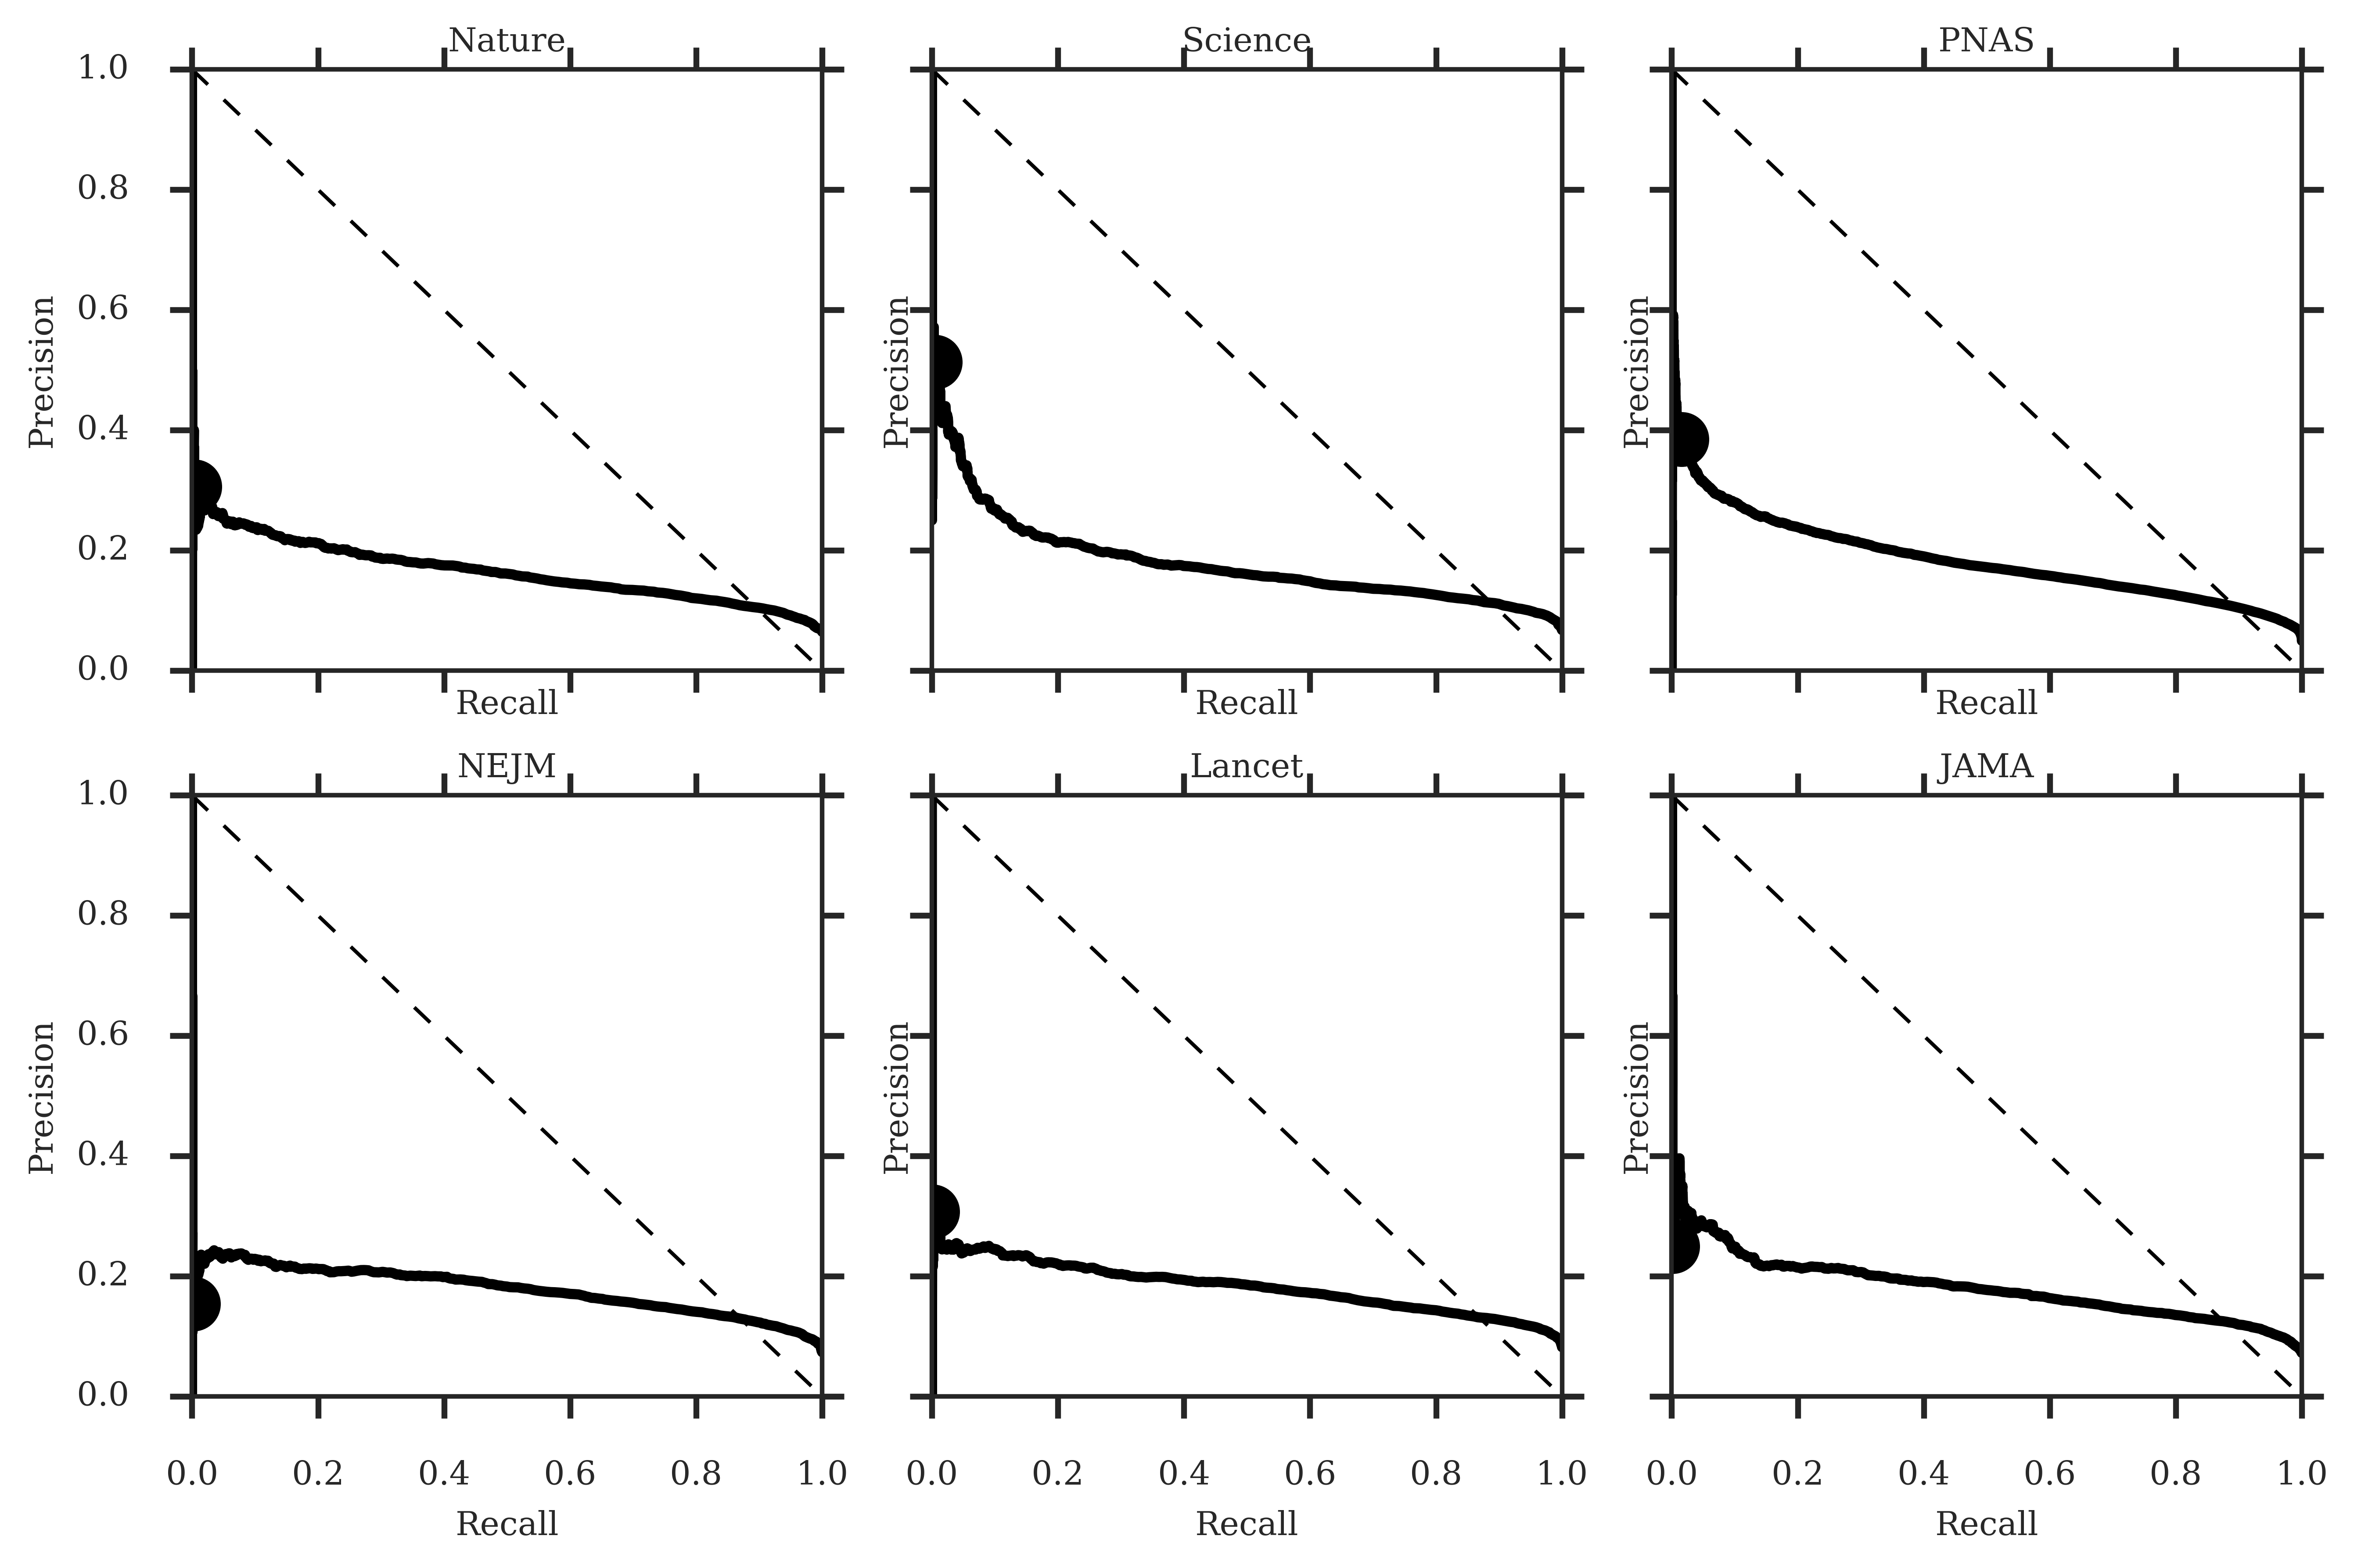

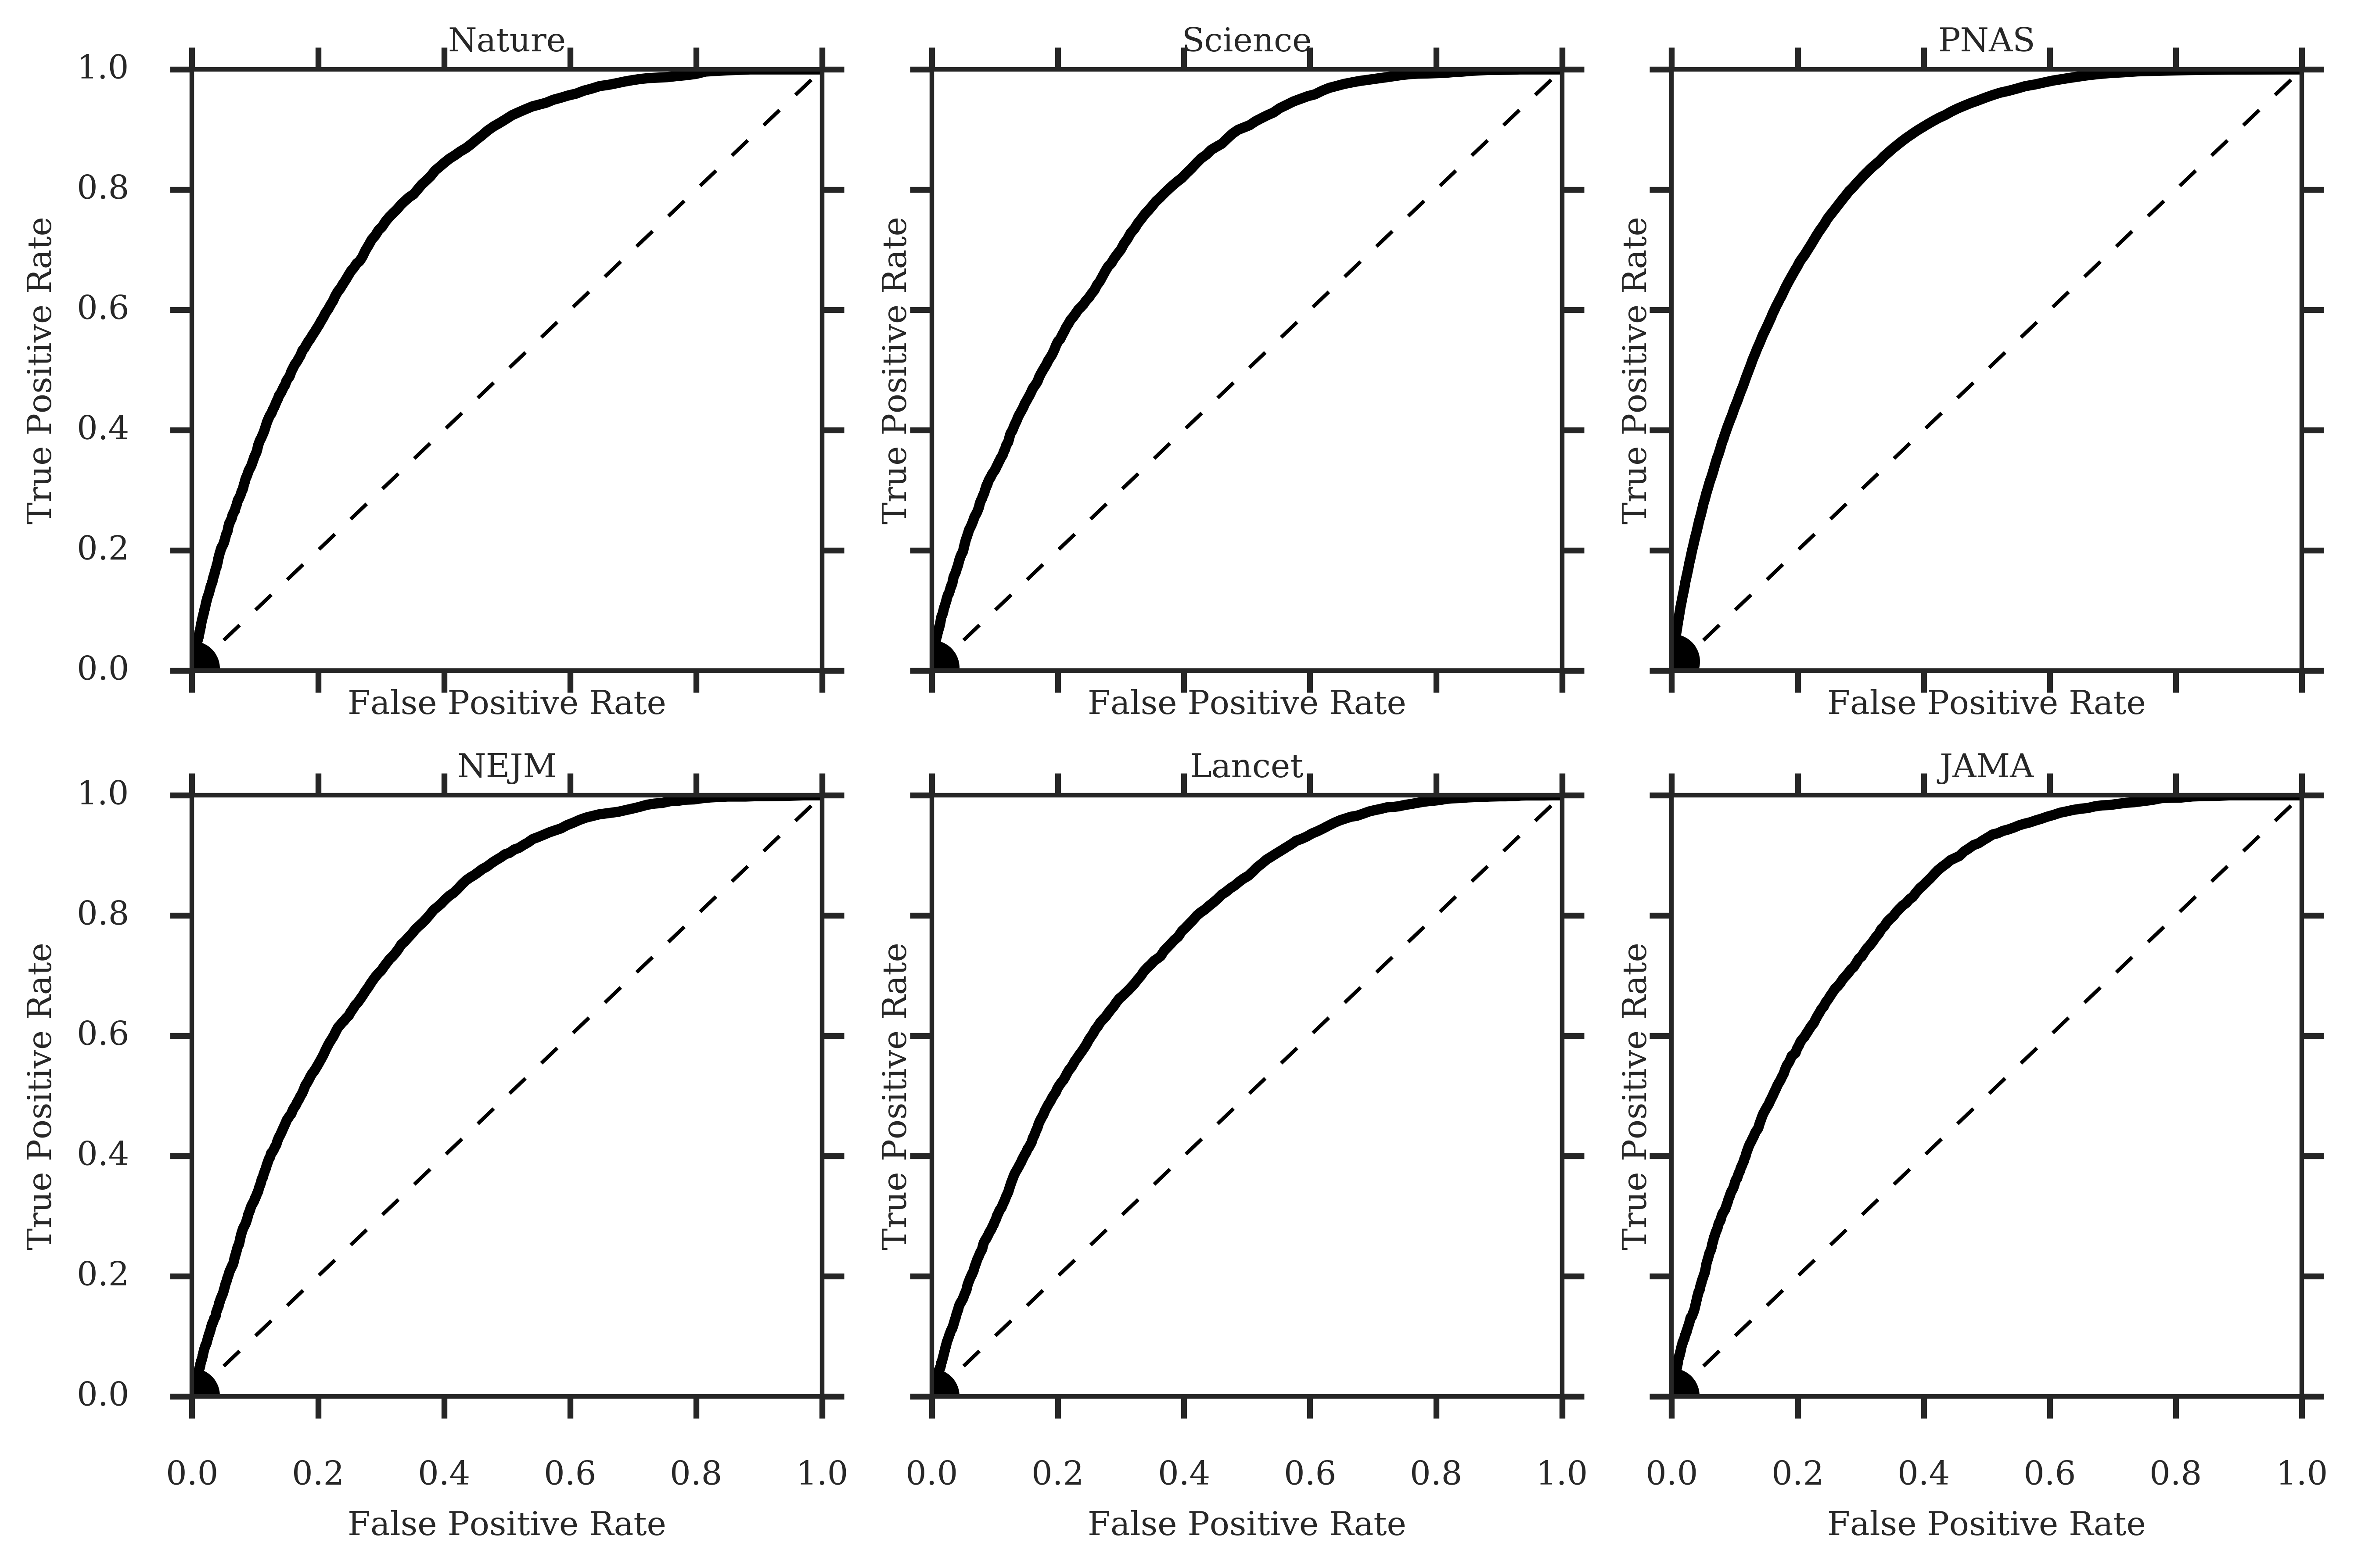

In [16]:
results_full = []
include_prc = True
nrows, ncols = 2,3
if include_prc:
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(ncols*3, nrows*3))
    fig1, ax1 = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(ncols*3, nrows*3))
    print "Created figure with %s rows and %s columns" % (nrows, ncols)
    ax = ax.flatten()
    ax1 = ax1.flatten()

formula = base_formula
for i, (jid, jname) in enumerate(MULTIDISCIPLINARY_JOURNAL_NAMES + MEDICAL_JOURNAL_NAMES):
    if i > 2:
        formula = "%s %s" % (base_formula, med_j_formula)
    measures, summary = model_fit(df[df.source_j == jname], formula, include_prc=include_prc)
    prc = measures.pop("prc", None)
    roc = measures.pop("roc", None)
    if include_prc and prc is not None and roc is not None:
        ## PRC
        plot_prc(prc, ax=ax[i], color="k")
        ax[i].plot([measures["recall"]], [measures["precision"]], marker="o",
                   color="k", linestyle="none", ms=15)
        ax[i].plot([0,1], [1,0], "--k", linewidth=1)
        ax[i].set_title(jid)
        ax[i].set_xlabel("Recall")
        ax[i].set_ylabel("Precision")
        ## ROC
        plot_prc(roc, ax=ax1[i], color="k")
        ax1[i].plot([measures["fpr"]], [measures["tpr"]], marker="o",
                   color="k", linestyle="none", ms=15)
        ax1[i].plot([0,1], [0,1], "--k", linewidth=1)
        ax1[i].set_title(jid)
        ax1[i].set_xlabel("False Positive Rate")
        ax1[i].set_ylabel("True Positive Rate")
    print i, jid, jname
    print measures
    print display(summary)
    results_full.append((jid, (measures, summary)))
if include_prc:
    fig.tight_layout()
    fig.savefig("PRC_model.%s.journal.pdf" % MODEL_SUFFIX, bbox_inches="tight")
    fig1.tight_layout()
    fig1.savefig("ROC_model.%s.journal.pdf" % MODEL_SUFFIX, bbox_inches="tight")

In [17]:
plot_data = pd.DataFrame()
journals = []
title = "Gender"
for jid, (m, s) in results_full:
    journals.append(jid)
    t = s.tables[1].ix[s.tables[1].index.str.startswith("C(gender"), ["Coef.", "P>|z|"]]
    t.ix[t["P>|z|"] > 0.005, "Coef."] = 0.
    plot_data[jid] = t["Coef."]
    
display(plot_data)

Nature  Science      PNAS  NEJM  Lancet  JAMA
C(gender, levels=GENDERS)[T.F]     0.0      0.0 -0.132800   0.0     0.0   0.0
C(gender, levels=GENDERS)[T.M]     0.0      0.0 -0.153567   0.0     0.0   0.0

Nature  Science      PNAS  NEJM  Lancet  JAMA  \
C(gender, levels=GENDERS)[T.F]     0.0      0.0 -0.132800   0.0     0.0   0.0   
C(gender, levels=GENDERS)[T.M]     0.0      0.0 -0.153567   0.0     0.0   0.0   

                                Overall  
C(gender, levels=GENDERS)[T.F]  -0.0208  
C(gender, levels=GENDERS)[T.M]  -0.0367

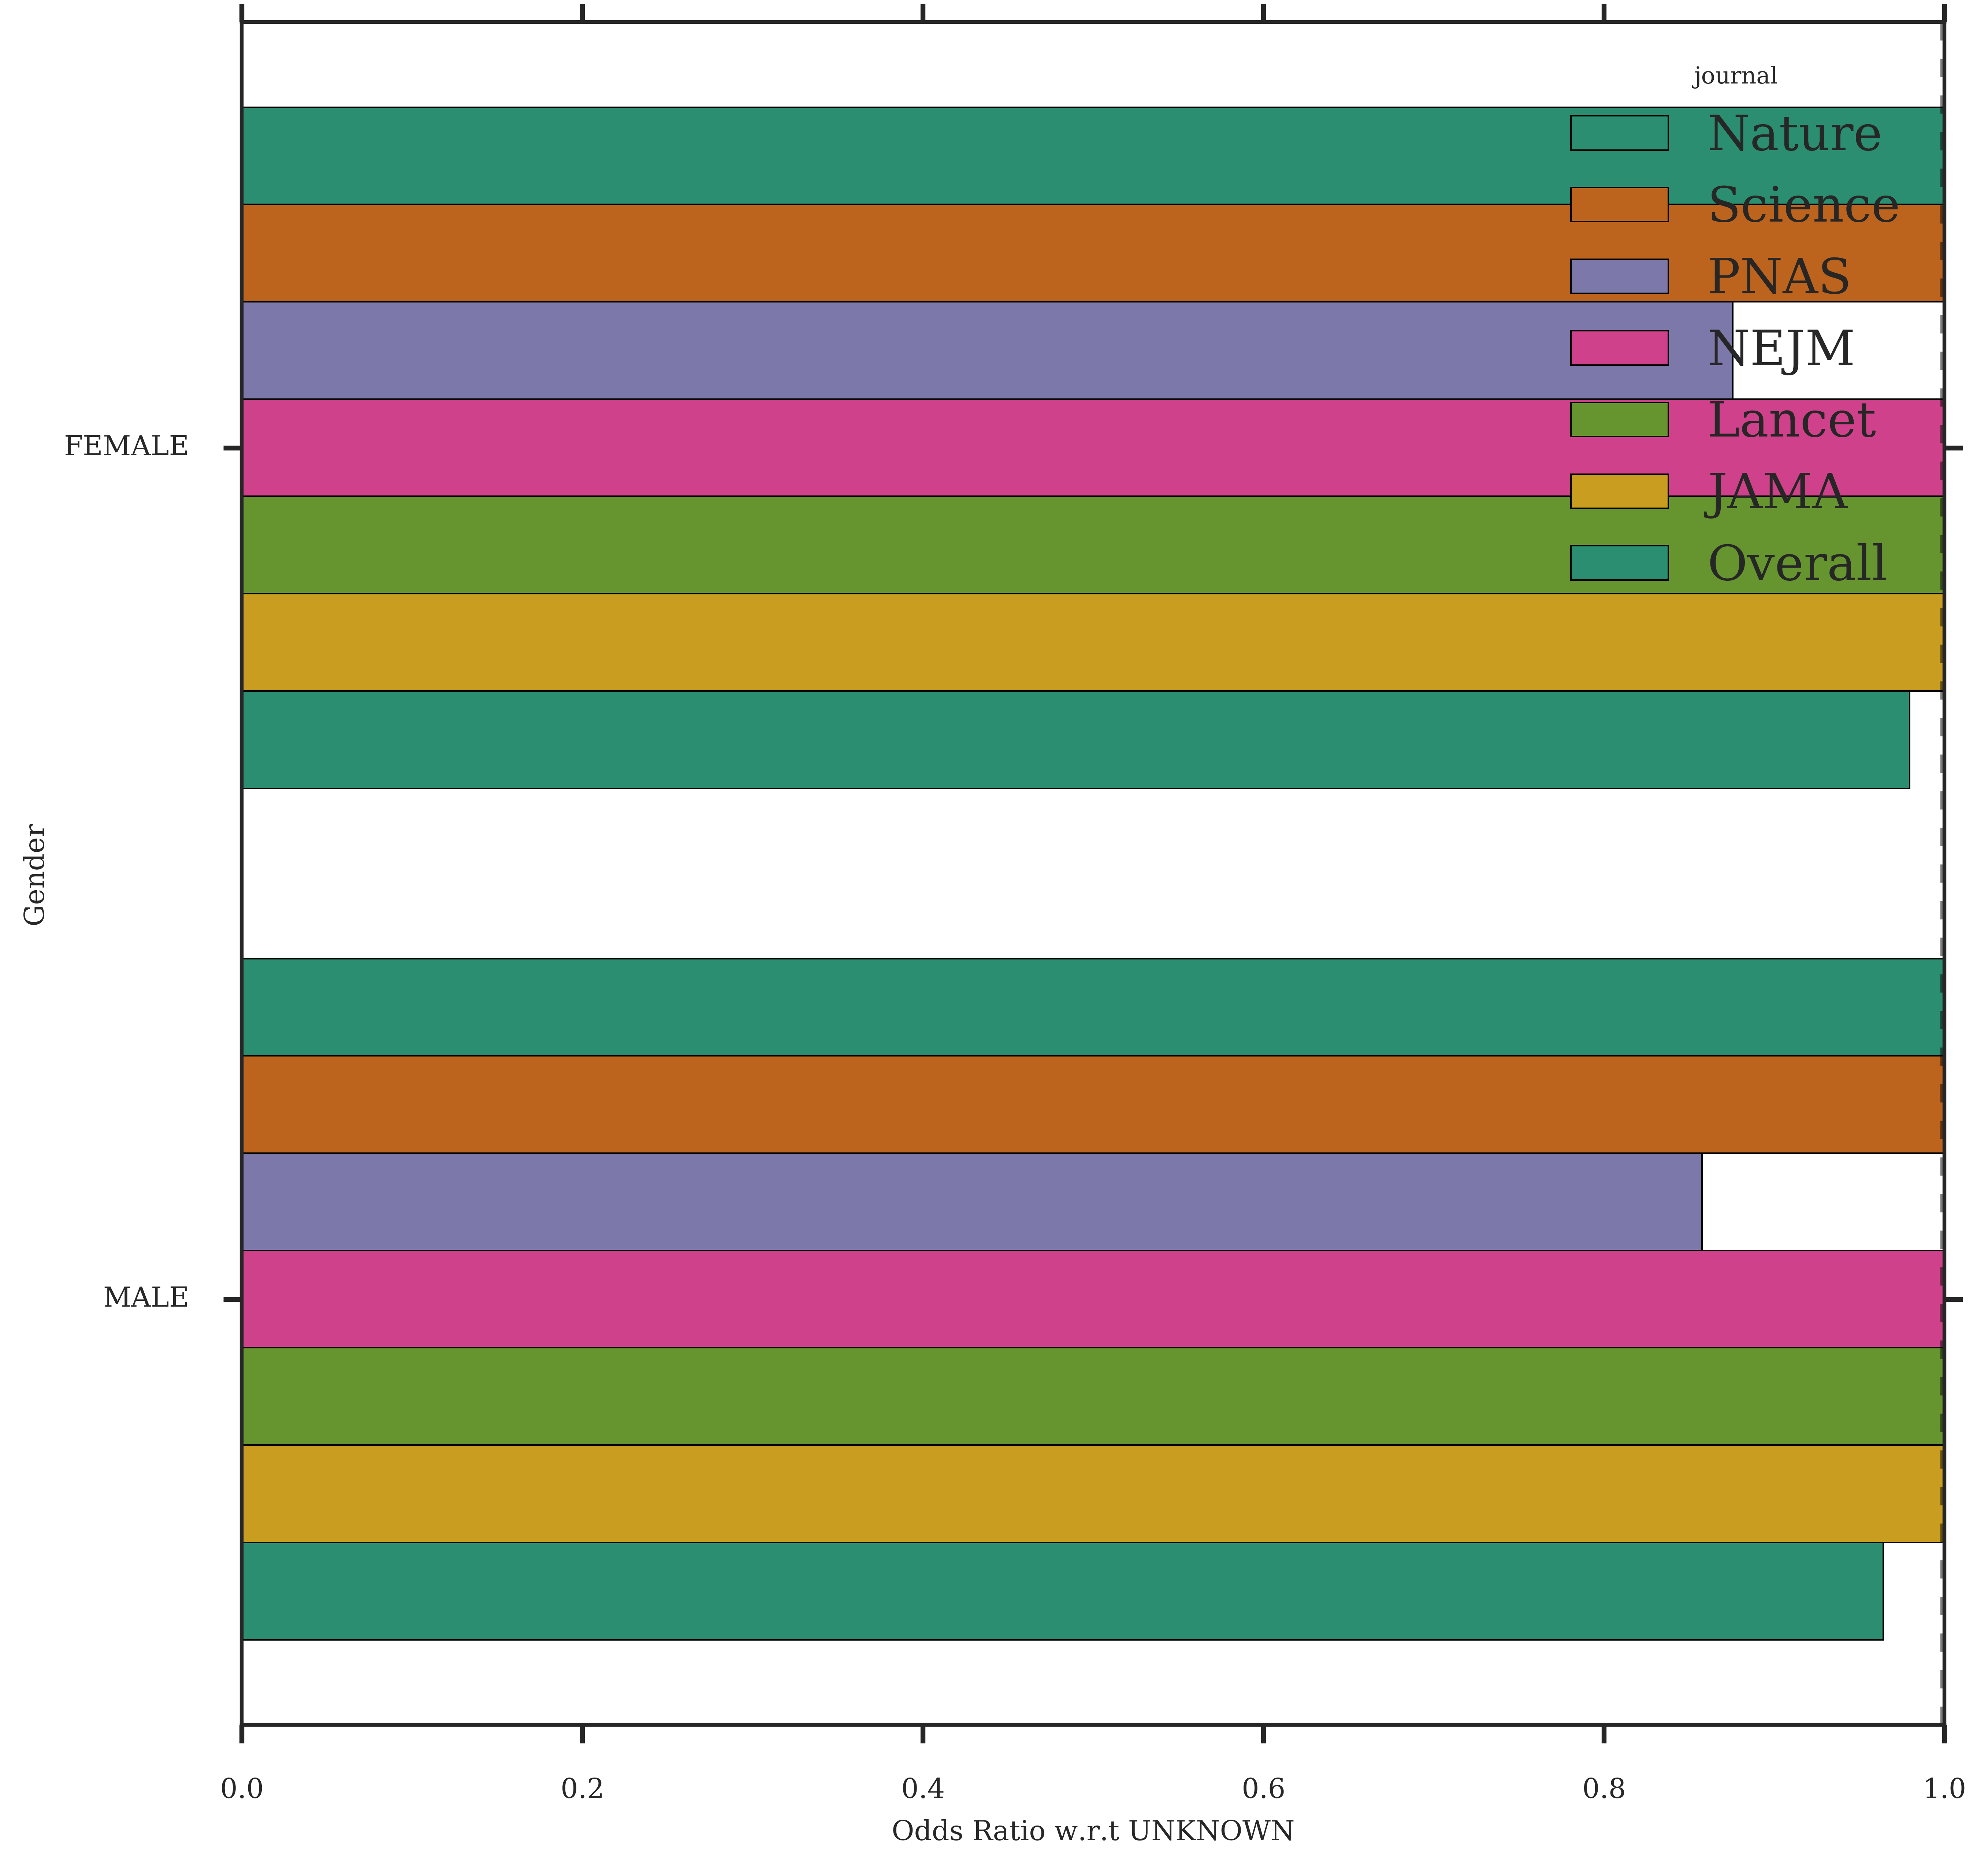

In [18]:
fig, ax = plt.subplots(1,1, sharex=True, figsize=(10,10))
plot_data = pd.DataFrame()
journals = []
GENDER_NAMES = ["UNKNOWN", "FEMALE", "MALE"]
title = "Gender"
for jid, (m, s) in results_full:
    journals.append(jid)
    t = s.tables[1].ix[s.tables[1].index.str.startswith("C(gender"), ["Coef.", "P>|z|"]]
    t.ix[t["P>|z|"] > 0.005, "Coef."] = 0.
    plot_data[jid] = t["Coef."]

plot_data["Overall"] = [-0.0208, -0.0367]
journals.append("Overall")
display(plot_data)
        
colors = sns.color_palette("dark", plot_data.shape[0])
colors = ["red", "blue"]
pdata = pd.melt(np.exp(plot_data).reset_index(), id_vars=["index"], value_vars=plot_data.columns.tolist())
pdata.columns = ["index", "journal", "value"]
ax = sns.barplot(data=pdata,
           y="index", x="value", hue="journal",
                palette=sns.color_palette("Dark2"))
ax.set_yticklabels(GENDER_NAMES[1:])
ax.axvline(1.0, linestyle="--", color="black", alpha=0.5)
ax.set_ylabel("Gender")
ax.set_xlabel("Odds Ratio w.r.t %s" % GENDER_NAMES[0])
plt.savefig("Gender_coeffs.%s.journal.pdf" % MODEL_SUFFIX, bbox_inches="tight")

Nature  Science  \
C(source_country, levels=TOP_15_COUNTRIES)[T.UN...  0.000000  0.00000   
C(source_country, levels=TOP_15_COUNTRIES)[T.UK]    0.000000  0.00000   
C(source_country, levels=TOP_15_COUNTRIES)[T.JA...  0.402285  0.48947   
C(source_country, levels=TOP_15_COUNTRIES)[T.GE...  0.000000  0.00000   
C(source_country, levels=TOP_15_COUNTRIES)[T.FR...  0.000000  0.00000   
C(source_country, levels=TOP_15_COUNTRIES)[T.IT...  0.000000  0.00000   
C(source_country, levels=TOP_15_COUNTRIES)[T.CA...  0.000000  0.00000   
C(source_country, levels=TOP_15_COUNTRIES)[T.CH...  0.000000  0.00000   
C(source_country, levels=TOP_15_COUNTRIES)[T.AU...  0.000000  0.00000   
C(source_country, levels=TOP_15_COUNTRIES)[T.SP...  0.000000  0.00000   
C(source_country, levels=TOP_15_COUNTRIES)[T.NE...  0.000000  0.00000   
C(source_country, levels=TOP_15_COUNTRIES)[T.SW...  0.000000  0.00000   
C(source_country, levels=TOP_15_COUNTRIES)[T.IN...  0.000000  0.00000   
C(source_country, levels=TOP_15_COUNTRIES)[T.OT...  0.000000  0.00000   

                                                        PNAS      NEJM  \
C(source_country, levels=TOP_15_COUNTRIES)[T.UN...  0.000000  0.000000   
C(source_country, levels=TOP_15_COUNTRIES)[T.UK]    0.000000  0.000000   
C(source_country, levels=TOP_15_COUNTRIES)[T.JA...  0.369771  0.000000   
C(source_country, levels=TOP_15_COUNTRIES)[T.GE...  0.000000  0.000000   
C(source_country, levels=TOP_15_COUNTRIES)[T.FR...  0.000000  0.000000   
C(source_country, levels=TOP_15_COUNTRIES)[T.IT...  0.000000  0.441351   
C(source_country, levels=TOP_15_COUNTRIES)[T.CA...  0.000000  0.000000   
C(source_country, levels=TOP_15_COUNTRIES)[T.CH...  0.000000  0.000000   
C(source_country, levels=TOP_15_COUNTRIES)[T.AU...  0.000000  0.666917   
C(source_country, levels=TOP_15_COUNTRIES)[T.SP...  0.000000  0.000000   
C(source_country, levels=TOP_15_COUNTRIES)[T.NE...  0.000000  0.000000   
C(source_country, levels=TOP_15_COUNTRIES)[T.SW...  0.000000  0.000000   
C(source_country, levels=TOP_15_COUNTRIES)[T.IN...  0.000000  0.000000   
C(source_country, levels=TOP_15_COUNTRIES)[T.OT...  0.106245  0.000000   

                                                      Lancet  JAMA  
C(source_country, levels=TOP_15_COUNTRIES)[T.UN... -0.322156   0.0  
C(source_country, levels=TOP_15_COUNTRIES)[T.UK]   -0.214417   0.0  
C(source_country, levels=TOP_15_COUNTRIES)[T.JA...  0.000000   0.0  
C(source_country, levels=TOP_15_COUNTRIES)[T.GE... -0.314245   0.0  
C(source_country, levels=TOP_15_COUNTRIES)[T.FR...  0.000000   0.0  
C(source_country, levels=TOP_15_COUNTRIES)[T.IT... -0.412828   0.0  
C(source_country, levels=TOP_15_COUNTRIES)[T.CA...  0.000000   0.0  
C(source_country, levels=TOP_15_COUNTRIES)[T.CH...  0.000000   0.0  
C(source_country, levels=TOP_15_COUNTRIES)[T.AU...  0.000000   0.0  
C(source_country, levels=TOP_15_COUNTRIES)[T.SP...  0.000000   0.0  
C(source_country, levels=TOP_15_COUNTRIES)[T.NE...  0.000000   0.0  
C(source_country, levels=TOP_15_COUNTRIES)[T.SW...  0.000000   0.0  
C(source_country, levels=TOP_15_COUNTRIES)[T.IN...  0.000000   0.0  
C(source_country, levels=TOP_15_COUNTRIES)[T.OT...  0.000000   0.0

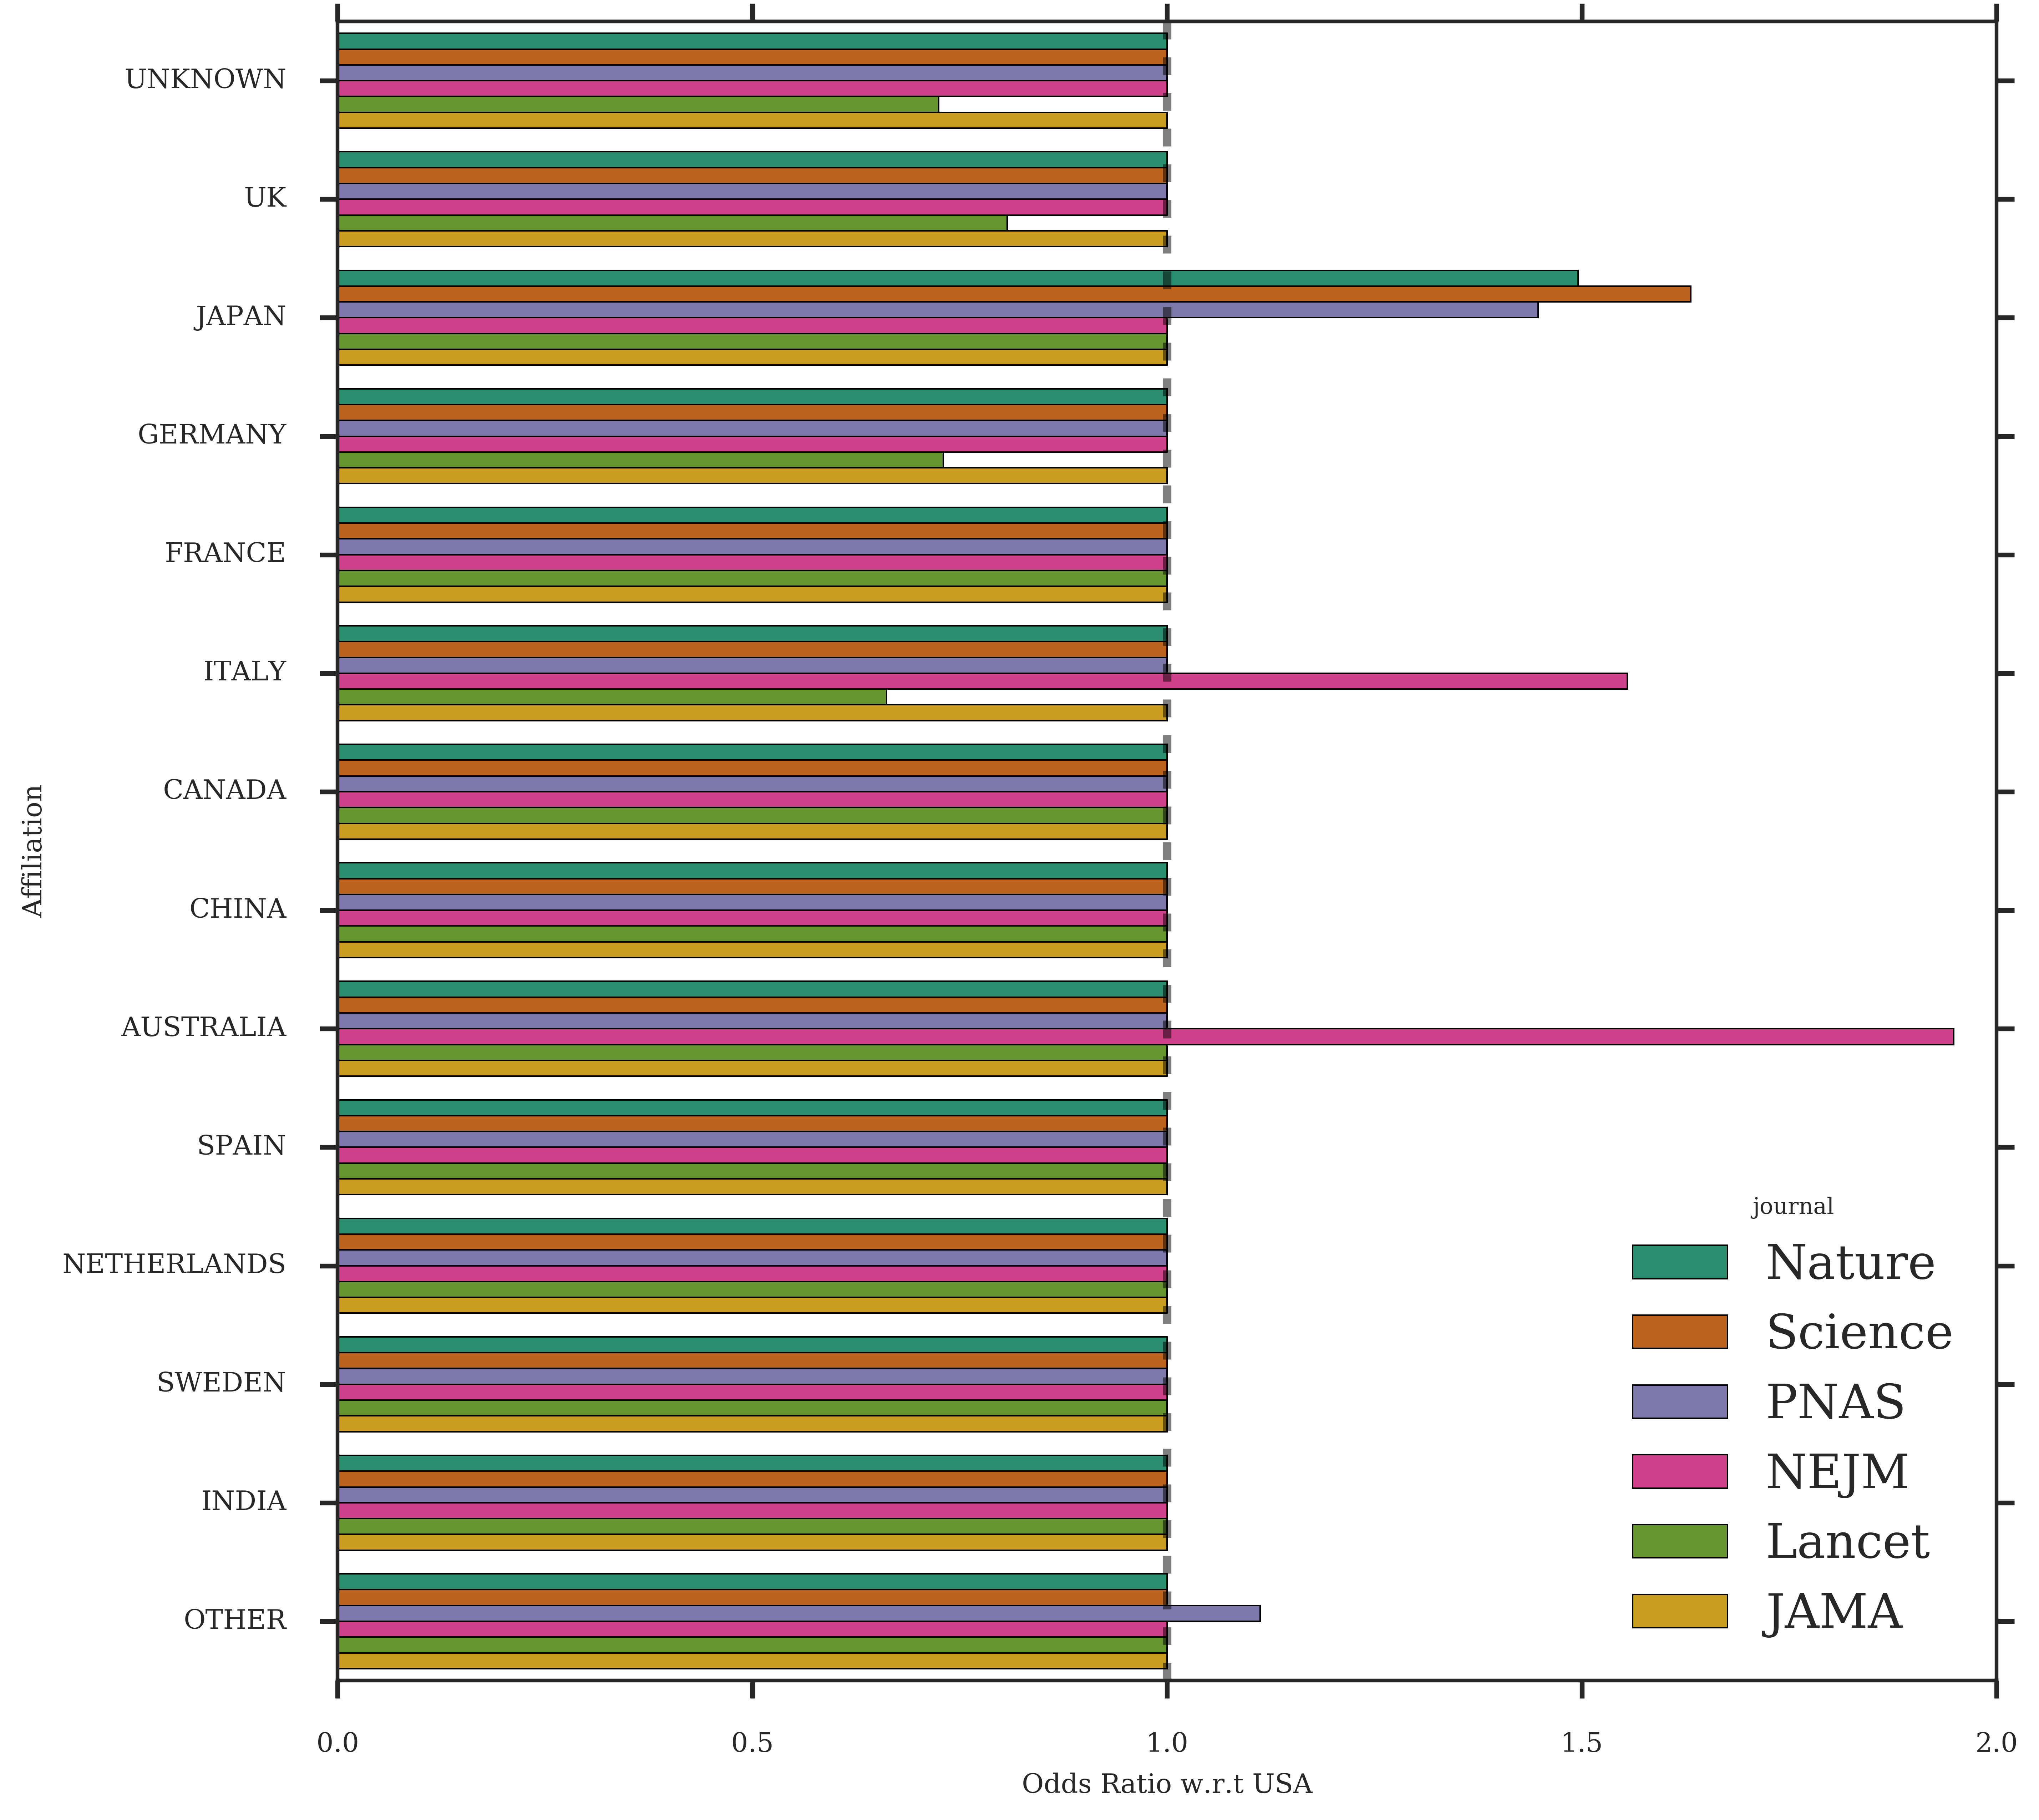

In [19]:
fig, ax = plt.subplots(1,1, sharex=True, figsize=(10,10))
plot_data = pd.DataFrame()
journals = []
title = "Affiliation"
for jid, (m, s) in results_full:
    journals.append(jid)
    t = s.tables[1].ix[s.tables[1].index.str.startswith("C(source_country"), ["Coef.", "P>|z|"]]
    t.ix[t["P>|z|"] > 0.005, "Coef."] = 0.
    plot_data[jid] = t["Coef."]

#plot_data["Overall"] = [-0.0208, -0.0367]
#journals.append("Overall")
display(plot_data)
        
pdata = pd.melt(np.exp(plot_data).reset_index(), id_vars=["index"], value_vars=plot_data.columns.tolist())
pdata.columns = ["index", "journal", "value"]
ax = sns.barplot(data=pdata,
           y="index", x="value", hue="journal",
                palette=sns.color_palette("Dark2"))
ax.set_yticklabels(TOP_15_COUNTRIES[1:])
ax.axvline(1.0, linestyle="--", color="black", alpha=0.5)
ax.set_ylabel("Affiliation")
ax.set_xlabel("Odds Ratio w.r.t %s" % TOP_15_COUNTRIES[0])
plt.savefig("Affiliation_coeffs.%s.journal.pdf" % MODEL_SUFFIX, bbox_inches="tight")

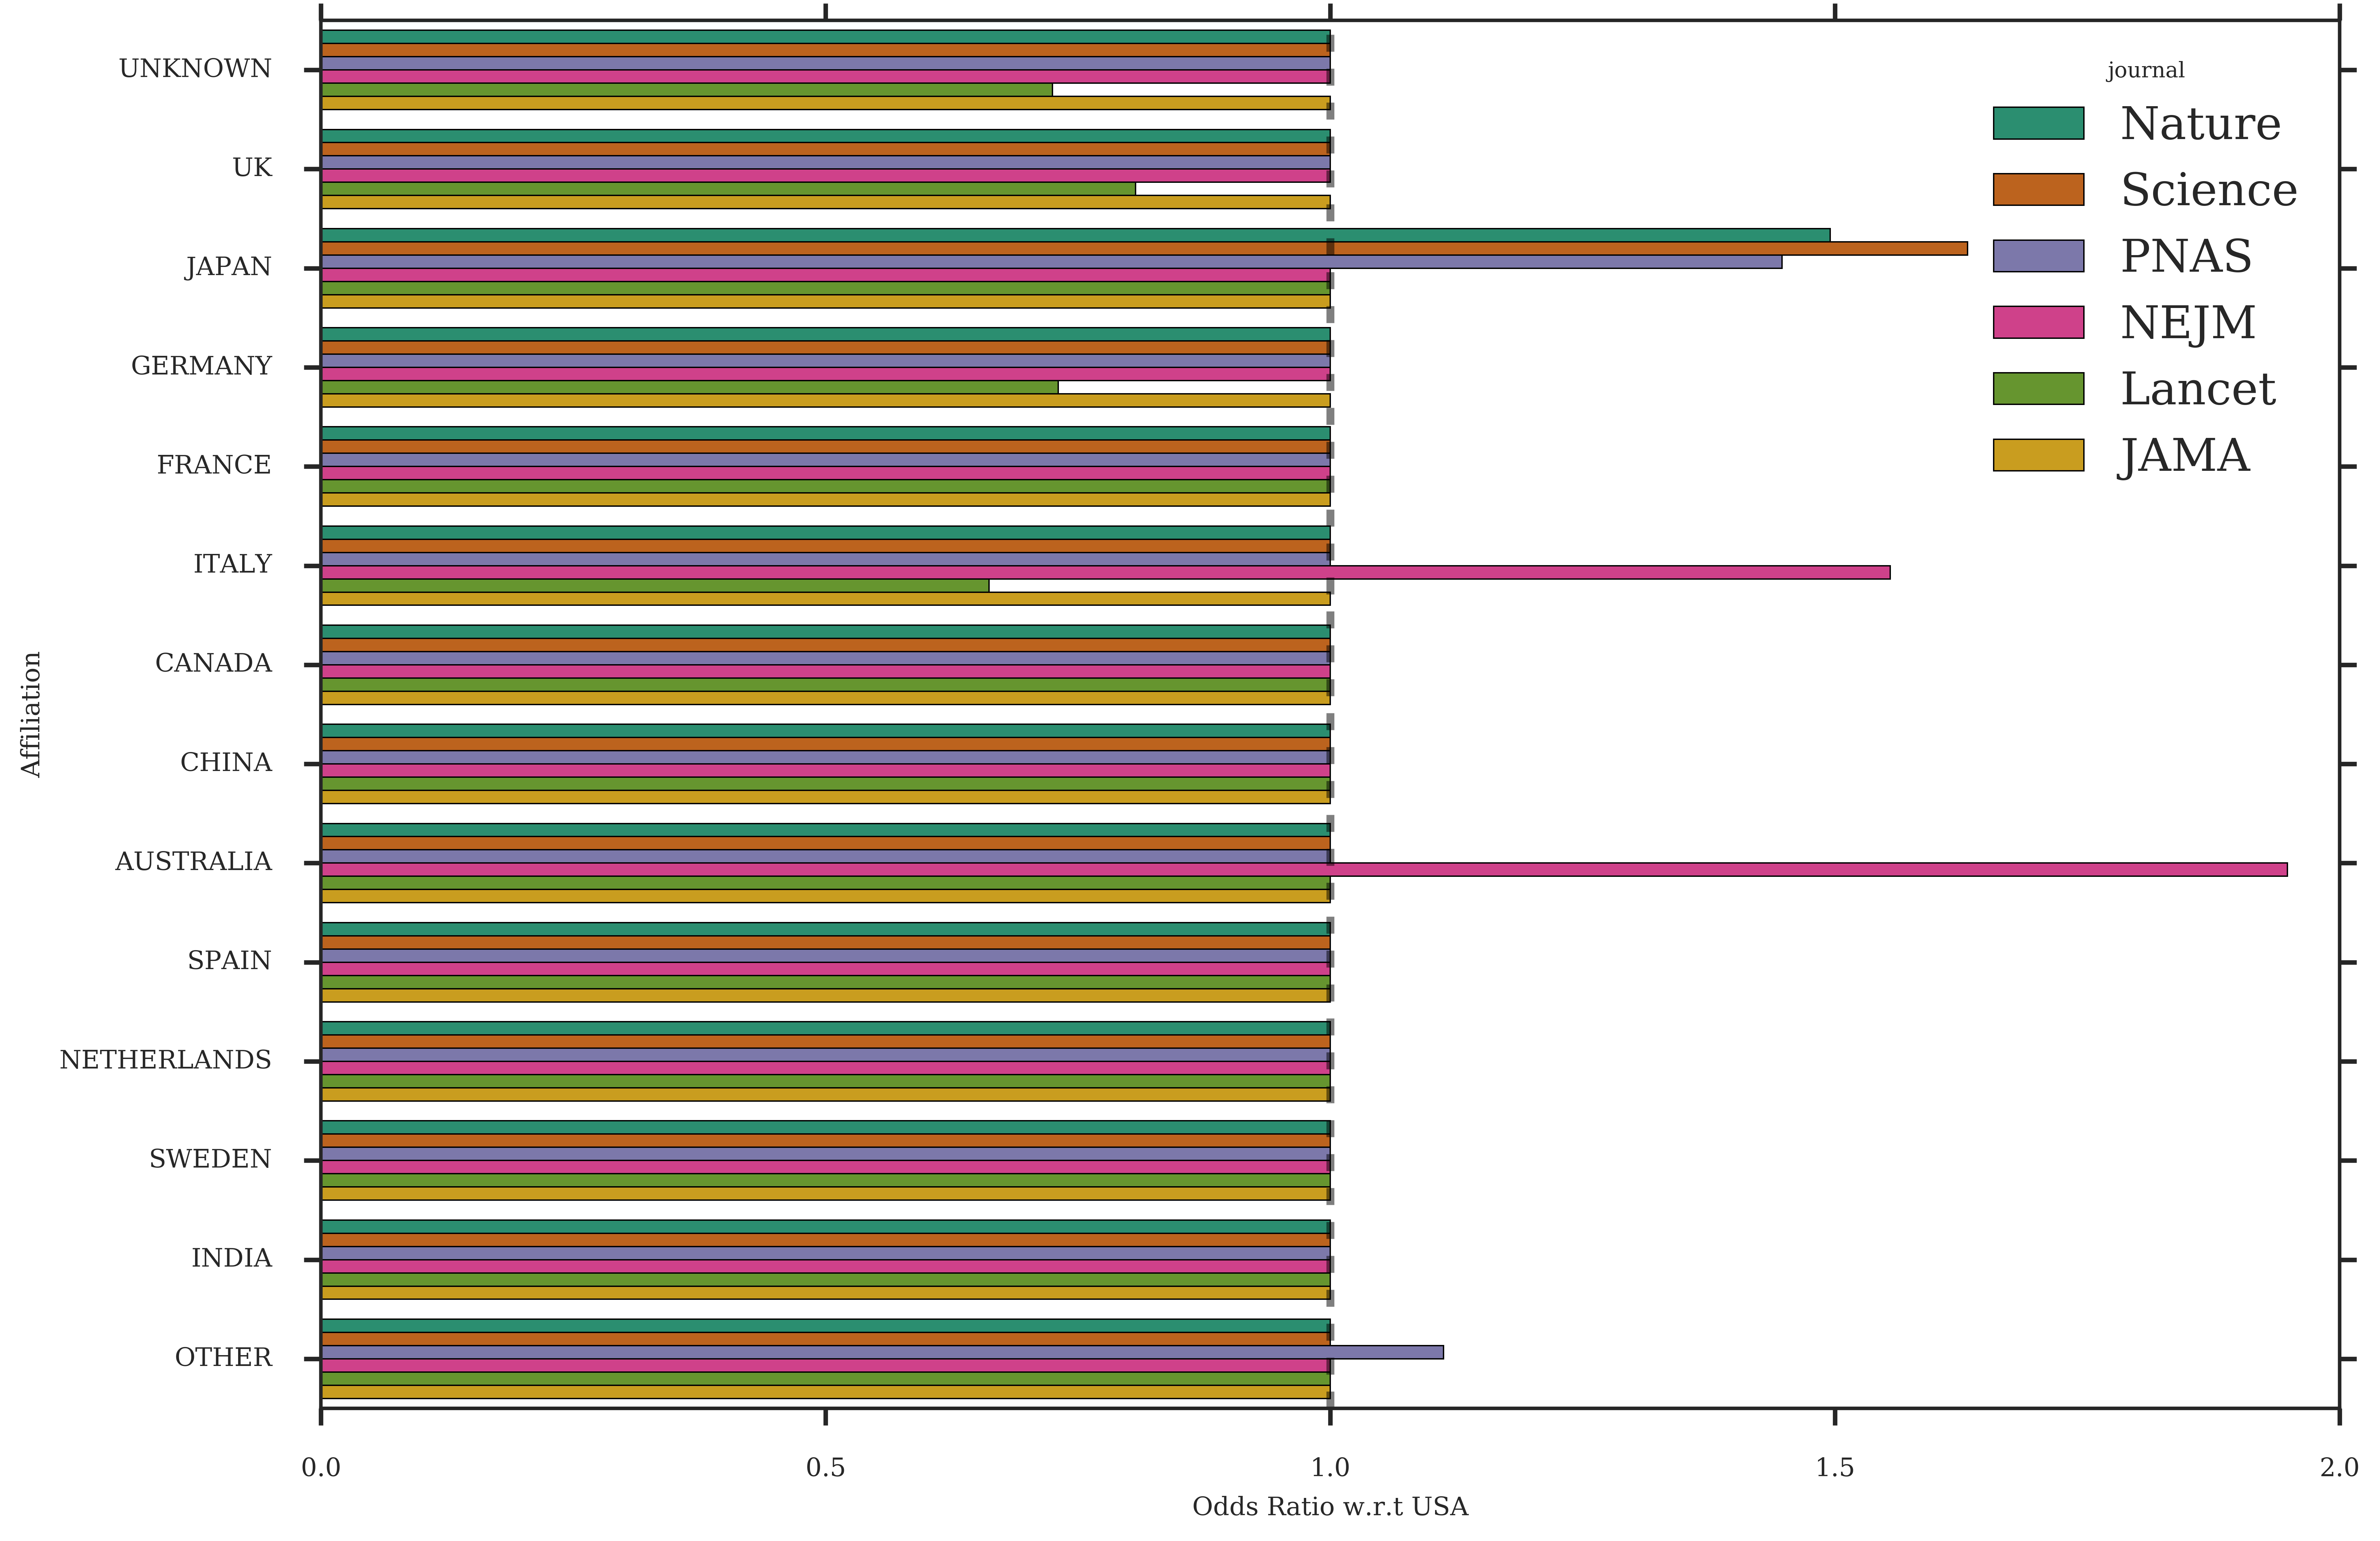

In [20]:
pdata = pd.melt(np.exp(plot_data).reset_index(), id_vars=["index"], value_vars=plot_data.columns.tolist())
pdata.columns = ["index", "journal", "value"]
ax = sns.barplot(data=pdata,
           y="index", x="value", hue="journal",
                palette=sns.color_palette("Dark2"))
ax.set_yticklabels(TOP_15_COUNTRIES[1:])
ax.axvline(1.0, linestyle="--", color="black", alpha=0.5)
ax.set_ylabel("Affiliation")
ax.set_xlabel("Odds Ratio w.r.t %s" % TOP_15_COUNTRIES[0])

Nature  Science  \
mf.MC(eth1, eth2, weights=eth_weight, levels=TO...  0.000000      0.0   
mf.MC(eth1, eth2, weights=eth_weight, levels=TO...  0.000000      0.0   
mf.MC(eth1, eth2, weights=eth_weight, levels=TO...  0.000000      0.0   
mf.MC(eth1, eth2, weights=eth_weight, levels=TO... -0.314729      0.0   
mf.MC(eth1, eth2, weights=eth_weight, levels=TO...  0.000000      0.0   
mf.MC(eth1, eth2, weights=eth_weight, levels=TO...  0.000000      0.0   
mf.MC(eth1, eth2, weights=eth_weight, levels=TO...  0.000000      0.0   
mf.MC(eth1, eth2, weights=eth_weight, levels=TO...  0.000000      0.0   
mf.MC(eth1, eth2, weights=eth_weight, levels=TO...  0.000000      0.0   
mf.MC(eth1, eth2, weights=eth_weight, levels=TO...  0.000000      0.0   
mf.MC(eth1, eth2, weights=eth_weight, levels=TO...  0.000000      0.0   
mf.MC(eth1, eth2, weights=eth_weight, levels=TO... -0.620265      0.0   
mf.MC(eth1, eth2, weights=eth_weight, levels=TO...  0.000000      0.0   
mf.MC(eth1, eth2, weights=eth_weight, levels=TO...  0.000000      0.0   

                                                        PNAS      NEJM  \
mf.MC(eth1, eth2, weights=eth_weight, levels=TO...  0.000000  0.000000   
mf.MC(eth1, eth2, weights=eth_weight, levels=TO... -0.162200  0.000000   
mf.MC(eth1, eth2, weights=eth_weight, levels=TO...  0.000000  0.000000   
mf.MC(eth1, eth2, weights=eth_weight, levels=TO... -0.271652  0.000000   
mf.MC(eth1, eth2, weights=eth_weight, levels=TO... -0.123161  0.541211   
mf.MC(eth1, eth2, weights=eth_weight, levels=TO... -0.142033  0.000000   
mf.MC(eth1, eth2, weights=eth_weight, levels=TO... -0.279292  0.000000   
mf.MC(eth1, eth2, weights=eth_weight, levels=TO...  0.000000  0.000000   
mf.MC(eth1, eth2, weights=eth_weight, levels=TO... -0.218991  0.000000   
mf.MC(eth1, eth2, weights=eth_weight, levels=TO...  0.000000  0.437677   
mf.MC(eth1, eth2, weights=eth_weight, levels=TO...  0.000000  0.000000   
mf.MC(eth1, eth2, weights=eth_weight, levels=TO... -0.298118  0.000000   
mf.MC(eth1, eth2, weights=eth_weight, levels=TO...  0.000000  0.000000   
mf.MC(eth1, eth2, weights=eth_weight, levels=TO...  0.000000  0.000000   

                                                      Lancet      JAMA  
mf.MC(eth1, eth2, weights=eth_weight, levels=TO...  0.000000  0.347908  
mf.MC(eth1, eth2, weights=eth_weight, levels=TO...  0.257091  0.000000  
mf.MC(eth1, eth2, weights=eth_weight, levels=TO...  0.000000  0.000000  
mf.MC(eth1, eth2, weights=eth_weight, levels=TO...  0.000000  0.000000  
mf.MC(eth1, eth2, weights=eth_weight, levels=TO...  0.000000  0.667456  
mf.MC(eth1, eth2, weights=eth_weight, levels=TO...  0.000000  0.000000  
mf.MC(eth1, eth2, weights=eth_weight, levels=TO...  0.000000  0.000000  
mf.MC(eth1, eth2, weights=eth_weight, levels=TO...  0.000000 -0.761149  
mf.MC(eth1, eth2, weights=eth_weight, levels=TO...  0.000000  0.000000  
mf.MC(eth1, eth2, weights=eth_weight, levels=TO...  0.000000  0.000000  
mf.MC(eth1, eth2, weights=eth_weight, levels=TO...  0.000000  0.000000  
mf.MC(eth1, eth2, weights=eth_weight, levels=TO...  0.000000  0.000000  
mf.MC(eth1, eth2, weights=eth_weight, levels=TO...  0.000000  0.000000  
mf.MC(eth1, eth2, weights=eth_weight, levels=TO...  0.000000  0.000000

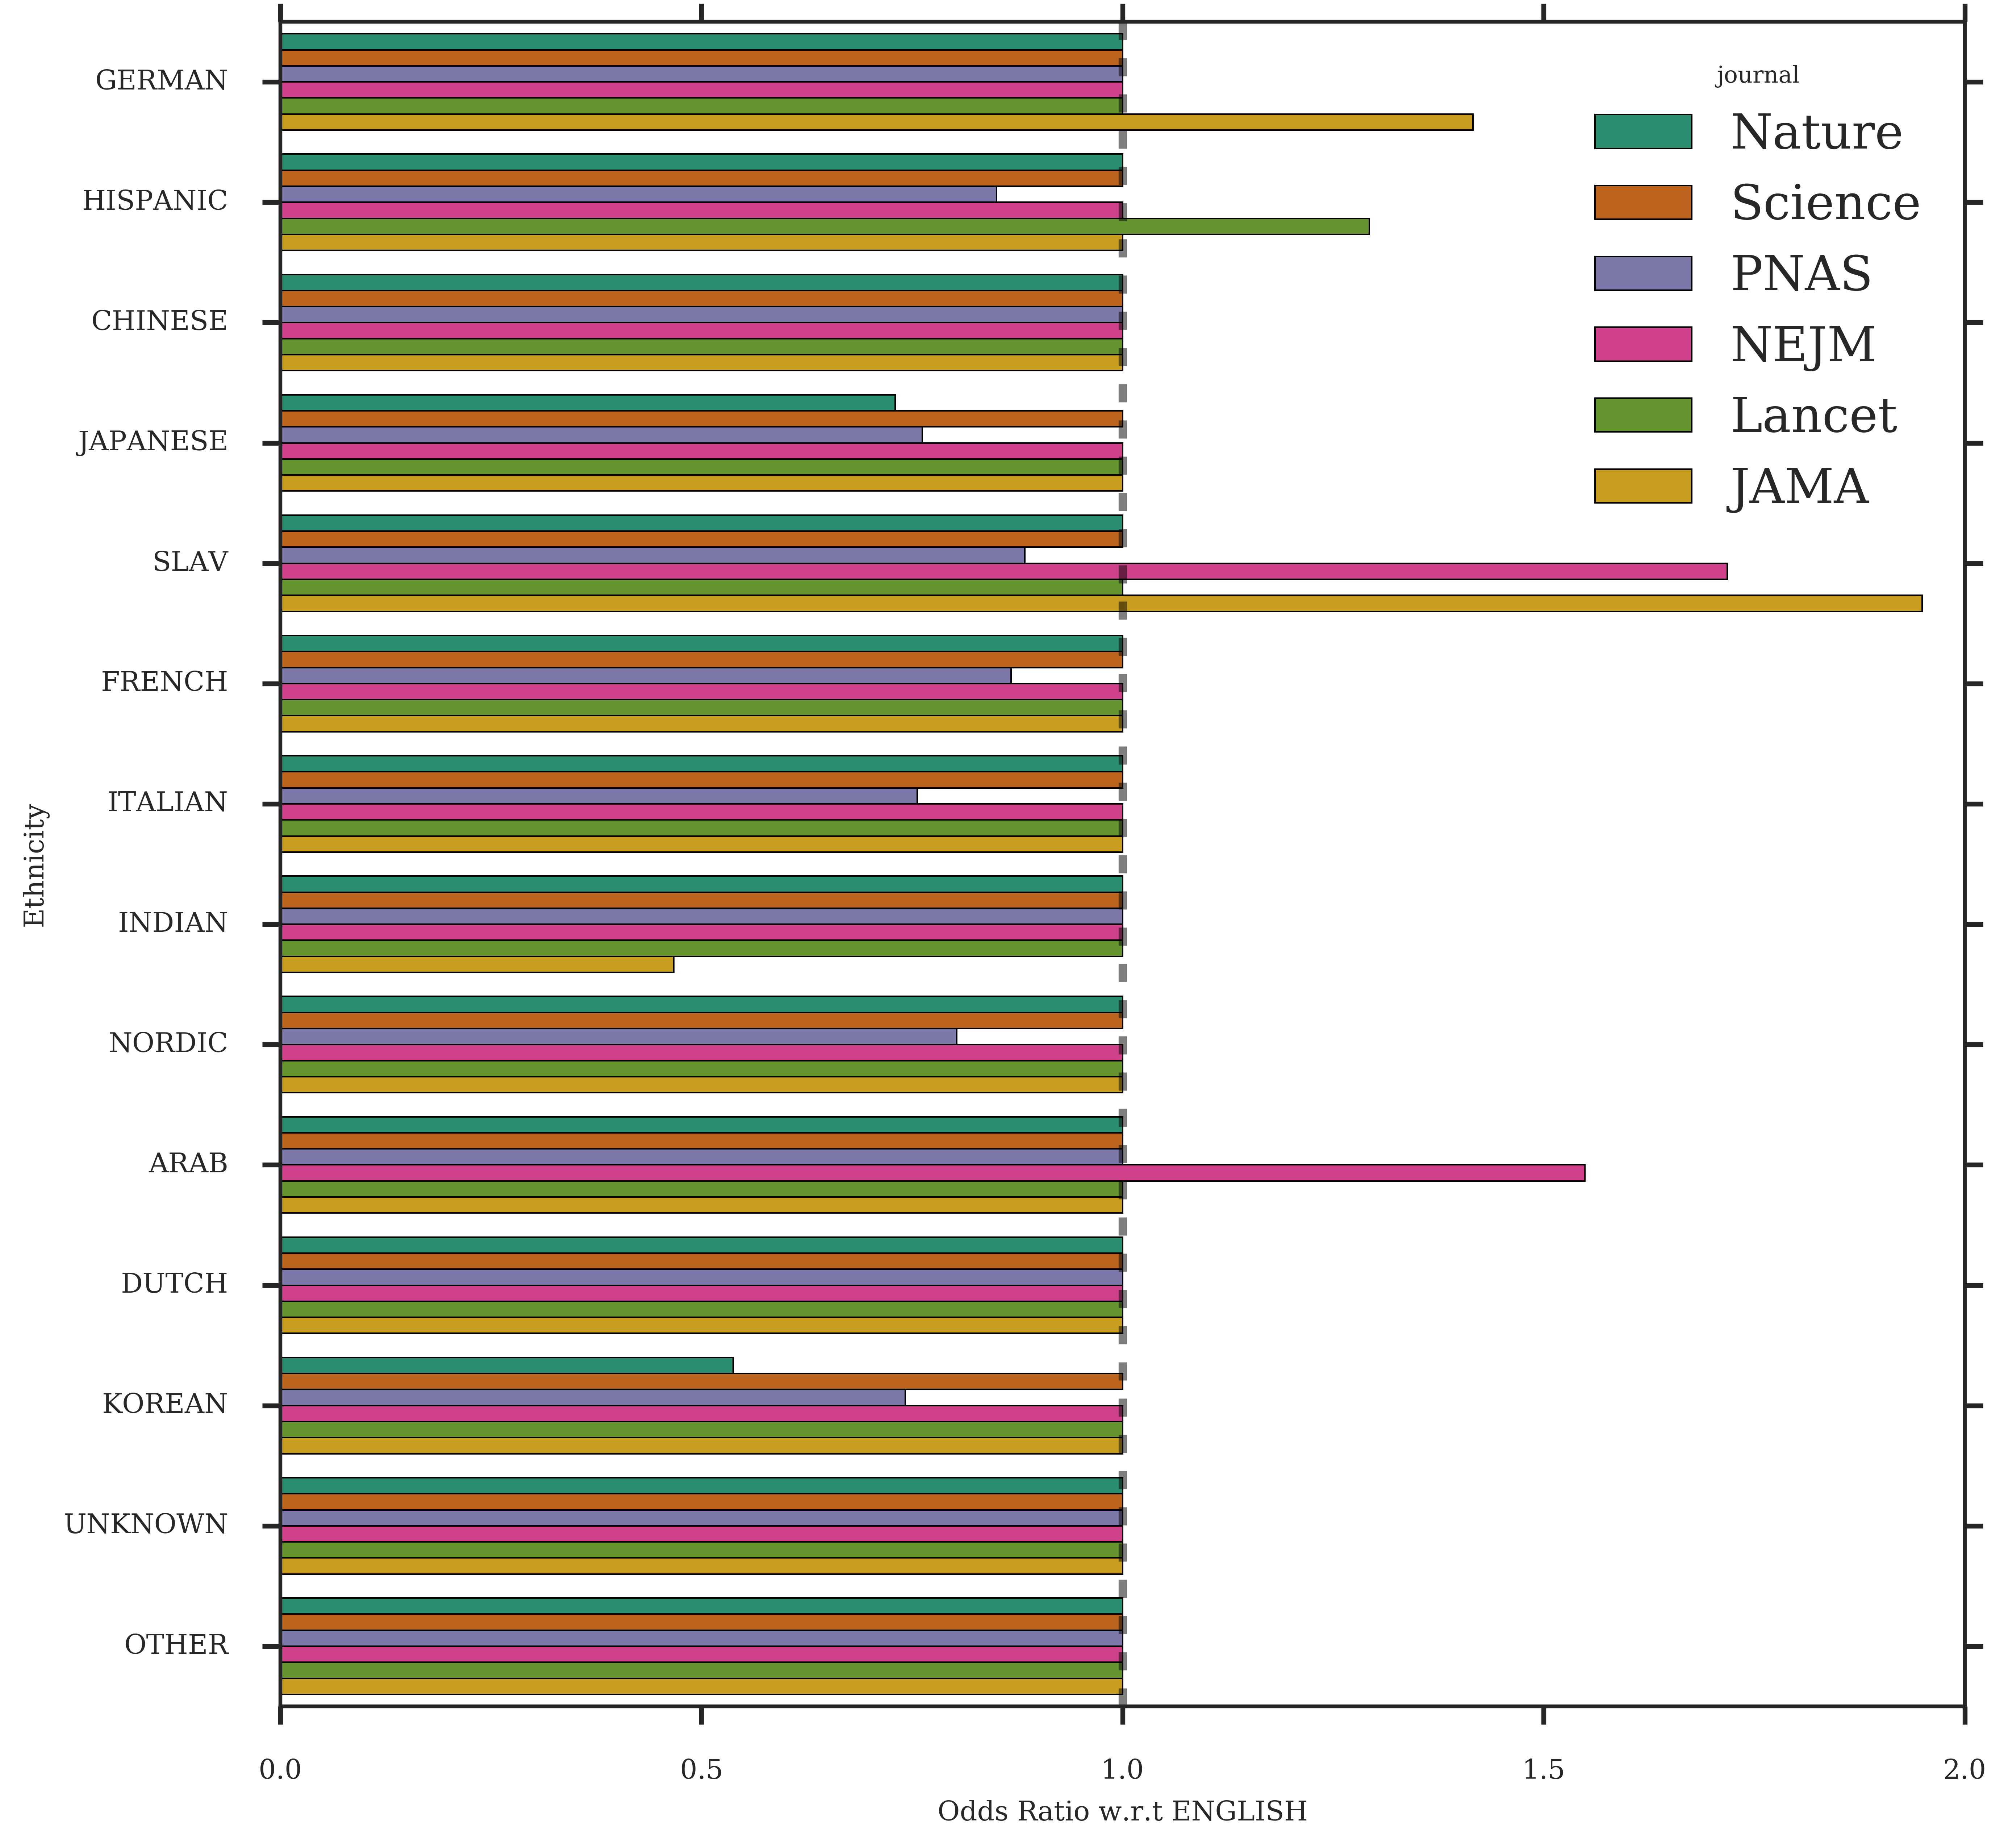

In [21]:
fig, ax = plt.subplots(1,1, sharex=True, figsize=(10,10))
plot_data = pd.DataFrame()
journals = []
title = "Ethnicity"
for jid, (m, s) in results_full:
    journals.append(jid)
    t = s.tables[1].ix[s.tables[1].index.str.startswith("mf.MC(eth1"), ["Coef.", "P>|z|"]]
    t.ix[t["P>|z|"] > 0.005, "Coef."] = 0.
    plot_data[jid] = t["Coef."]

#plot_data["Overall"] = [-0.0208, -0.0367]
#journals.append("Overall")
display(plot_data)
        
colors = sns.color_palette("dark", plot_data.shape[0])
colors = colors = sns.color_palette("dark", plot_data.shape[0])
pdata = pd.melt(np.exp(plot_data).reset_index(), id_vars=["index"], value_vars=plot_data.columns.tolist())
pdata.columns = ["index", "journal", "value"]
ax = sns.barplot(data=pdata,
           y="index", x="value", hue="journal",
                palette=sns.color_palette("Dark2"))
ax.set_yticklabels(TOP_15_ETHNICITIES[1:])
ax.axvline(1.0, linestyle="--", color="black", alpha=0.5)
ax.set_ylabel("Ethnicity")
ax.set_xlabel("Odds Ratio w.r.t %s" % TOP_15_ETHNICITIES[0])
plt.savefig("Ethnicity_coeffs.%s.journal.pdf" % MODEL_SUFFIX, bbox_inches="tight")

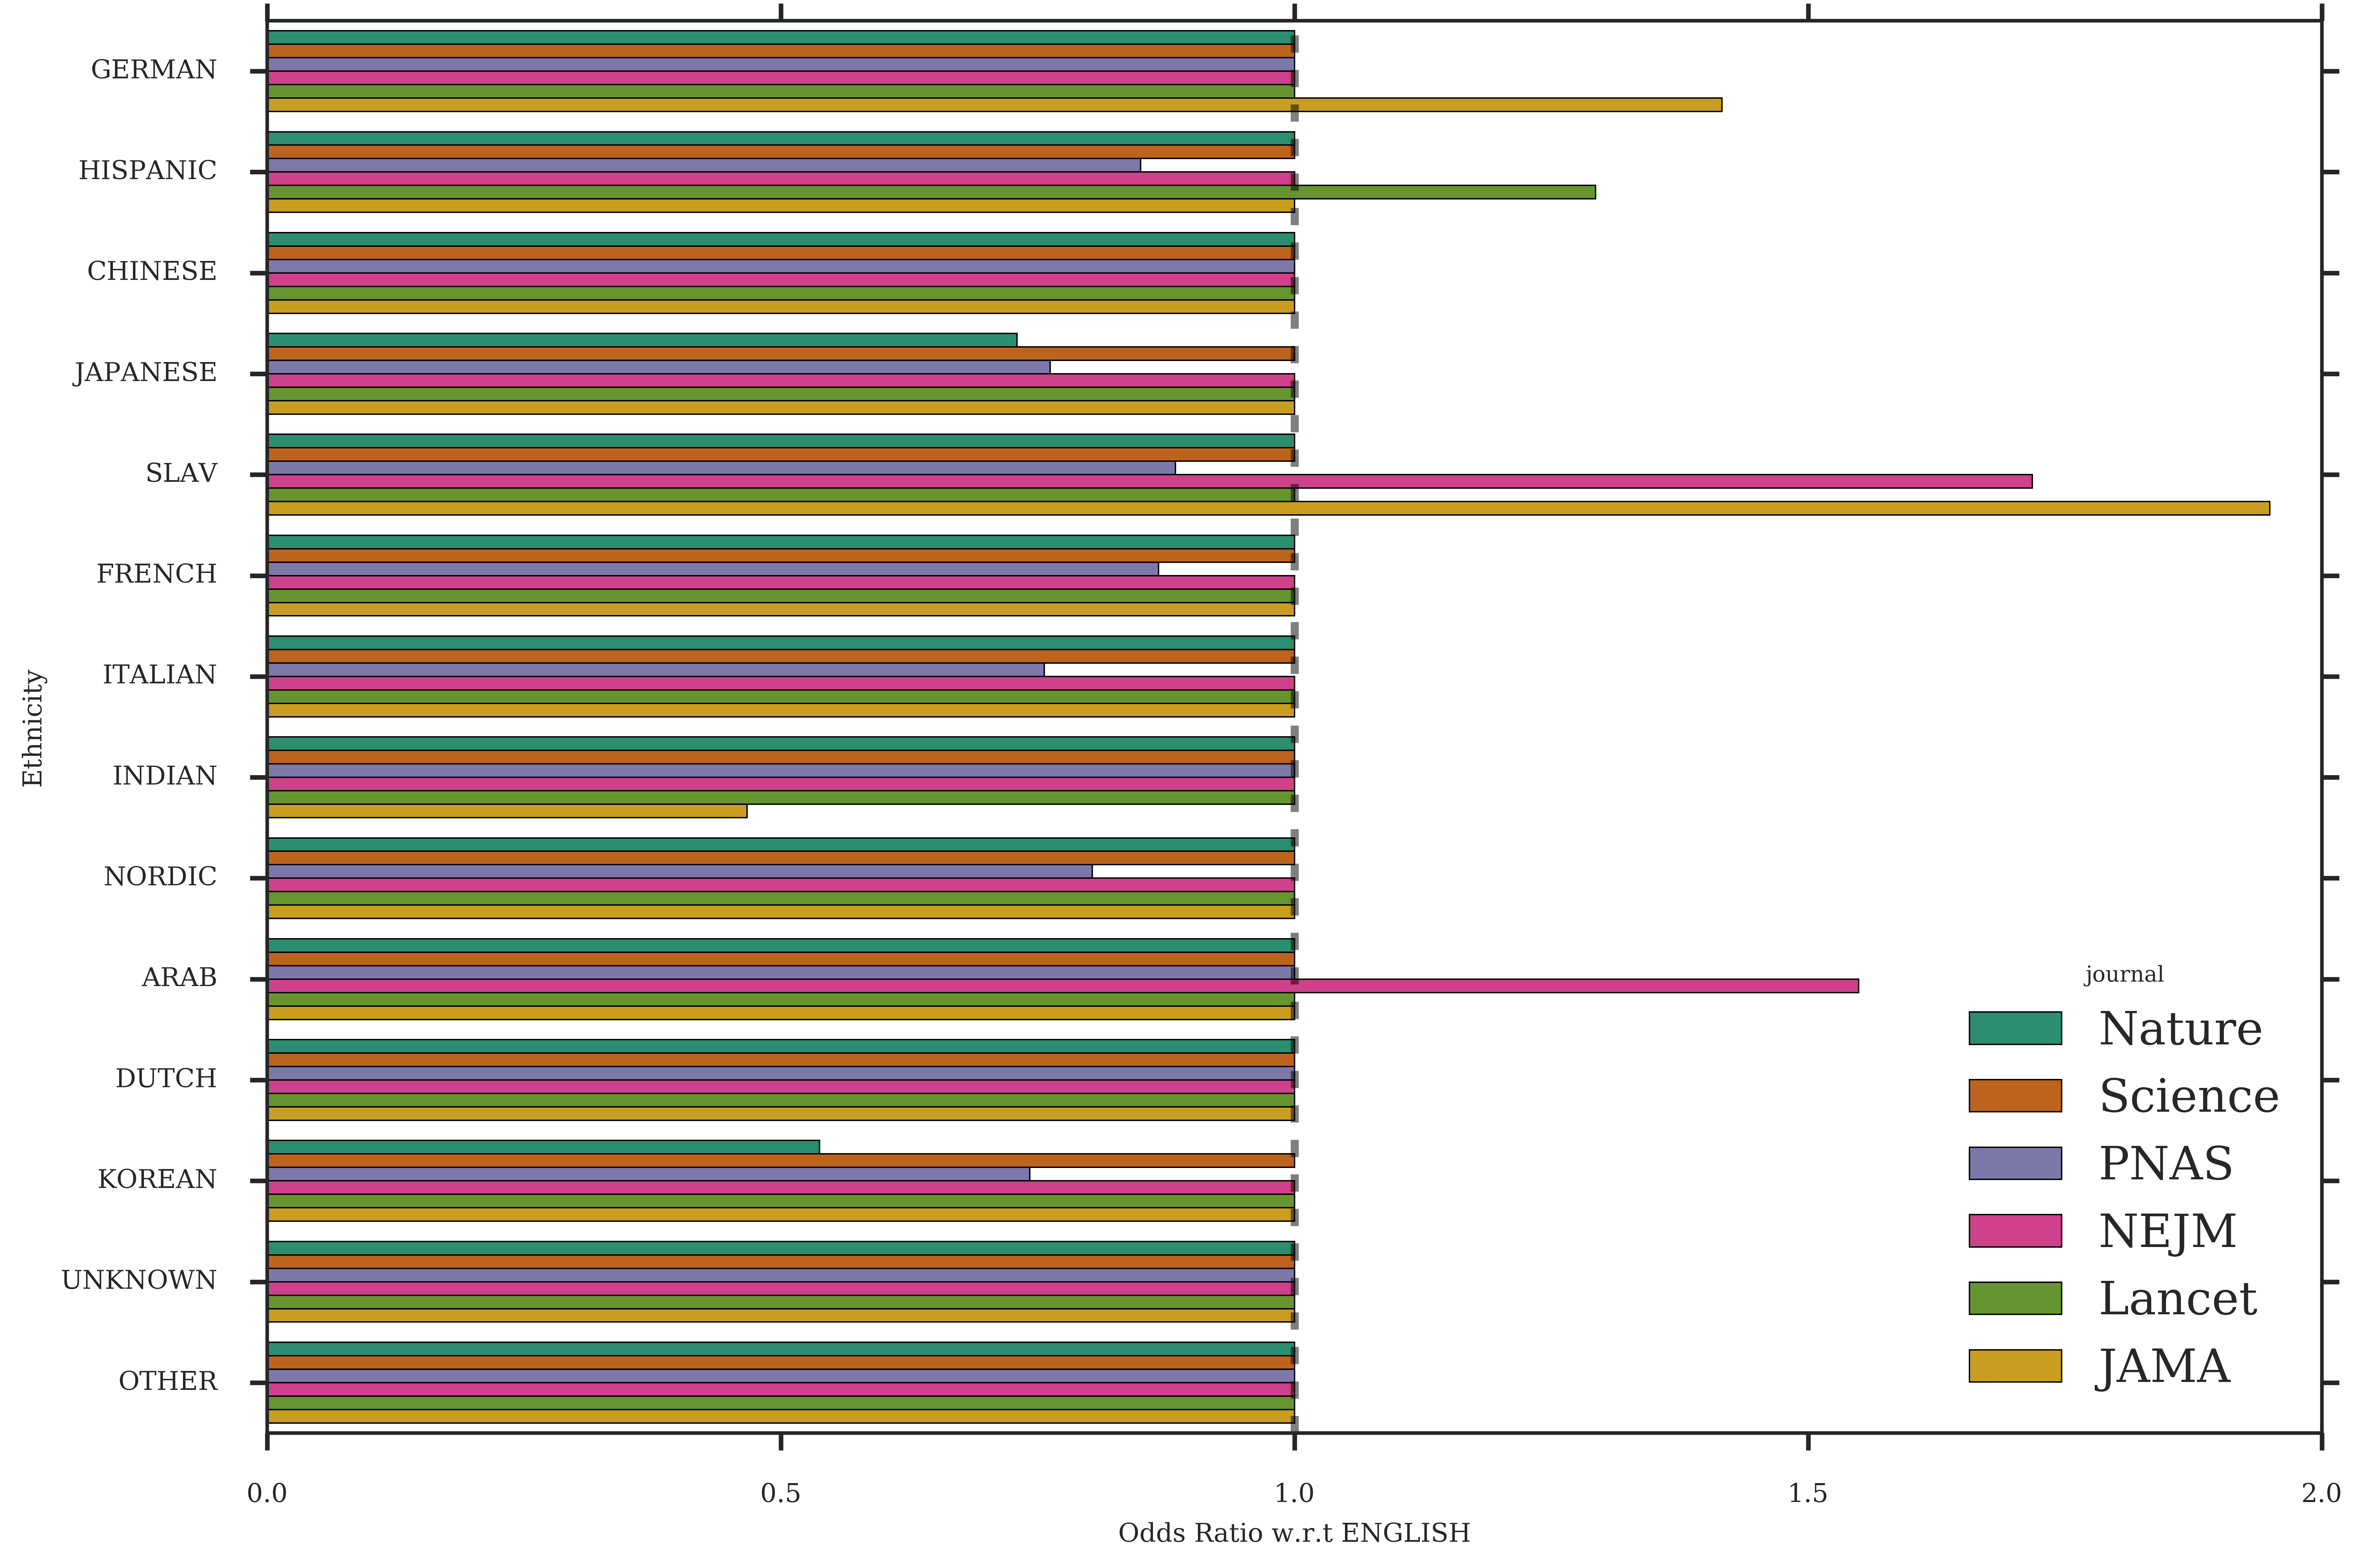

In [22]:
pdata = pd.melt(np.exp(plot_data).reset_index(), id_vars=["index"], value_vars=plot_data.columns.tolist())
pdata.columns = ["index", "journal", "value"]
ax = sns.barplot(data=pdata,
           y="index", x="value", hue="journal",
                palette=sns.color_palette("Dark2"))
ax.set_yticklabels(TOP_15_ETHNICITIES[1:])
ax.axvline(1.0, linestyle="--", color="black", alpha=0.5)
ax.set_ylabel("Ethnicity")
ax.set_xlabel("Odds Ratio w.r.t %s" % TOP_15_ETHNICITIES[0])

[(0.89411765336990356, 0.10196078568696976, 0.1098039224743836),
 (0.21602460800432688, 0.49487120380588578, 0.71987698697576341),
 (0.30426760128900115, 0.68329106055054012, 0.29293349969620797),
 (0.60083047361934894, 0.30814303335021531, 0.63169552298153153),
 (1.0, 0.50591311045721454, 0.0031372549487094226),
 (0.99315647868549106, 0.98700499826786559, 0.19915417450315831),
 (0.65845446095747096, 0.34122261685483596, 0.17079585352364723),
 (0.95850826852461857, 0.50846600392285535, 0.7449288887136124),
 (0.60000002384185791, 0.60000002384185791, 0.60000002384185791)]

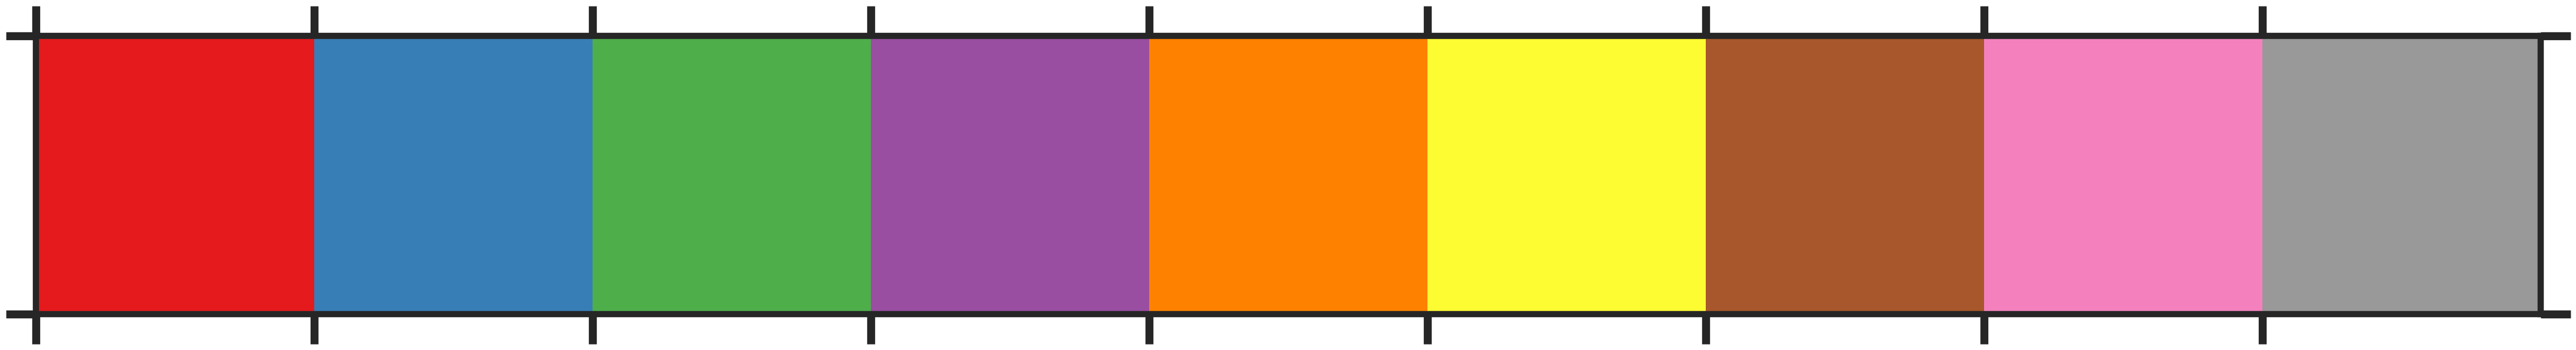

In [23]:
sns.choose_colorbrewer_palette("q")

In [24]:
dump(results_full, "results_all_model/%s/results_all_model.%s.journal.pkl" % (MODEL_VERSION, MODEL_SUFFIX))

['results_all_model/v4/results_all_model.v4.first_author.journal.pkl',
 'results_all_model/v4/results_all_model.v4.first_author.journal.pkl_01.npy',
 'results_all_model/v4/results_all_model.v4.first_author.journal.pkl_02.npy',
 'results_all_model/v4/results_all_model.v4.first_author.journal.pkl_03.npy',
 'results_all_model/v4/results_all_model.v4.first_author.journal.pkl_04.npy',
 'results_all_model/v4/results_all_model.v4.first_author.journal.pkl_05.npy',
 'results_all_model/v4/results_all_model.v4.first_author.journal.pkl_06.npy',
 'results_all_model/v4/results_all_model.v4.first_author.journal.pkl_07.npy',
 'results_all_model/v4/results_all_model.v4.first_author.journal.pkl_08.npy',
 'results_all_model/v4/results_all_model.v4.first_author.journal.pkl_09.npy',
 'results_all_model/v4/results_all_model.v4.first_author.journal.pkl_10.npy',
 'results_all_model/v4/results_all_model.v4.first_author.journal.pkl_11.npy',
 'results_all_model/v4/results_all_model.v4.first_author.journal.pkl_12

## Testing

In [41]:
%load_ext autoreload

In [56]:
%autoreload 2

In [54]:
%aimport model_functions

In [57]:
import model_functions as mf

MF reloaded 1


In [93]:
"Shub"[:2]

'Sh'